In [341]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [24]:
data = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24.csv')
data.loc[:,'charttime']  = pd.to_datetime(data.loc[:,'charttime'])
data = data.sort_values(['icustay_id', 'charttime'],ascending=True)
data.head()

,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
subject_id,,,,,,,
55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [25]:
print "loading lab data"
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
data = data[cols]
print "complete"

loading lab data
complete


In [26]:
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data.drop_duplicates('subject_id', keep = 'first')

print "The number of unique ICU stays = {}".format(data2.shape[0])
print "The number of unique patients  = {}".format(data3.shape[0])

# display the different measurements captured in the database query
labels = data.label.unique()
display(data.shape)
display(data[(data.label=='Lactate') & (~(data.valuenum.isnull()))].head())
display(labels)

The number of unique ICU stays = 59798
The number of unique patients  = 45260


(943120, 8)

,icustay_id,subject_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
3,200001,55973,F,Lactate,2181-11-25 19:27:00,1.4,NaN,0
26,200003,27513,M,Lactate,2199-08-03 01:55:00,5.1,abnormal,0
29,200003,27513,M,Lactate,2199-08-03 03:42:00,4.1,abnormal,0
36,200003,27513,M,Lactate,2199-08-03 17:52:00,2.6,abnormal,0
44,200006,10950,M,Lactate,2159-09-03 08:11:00,3.1,abnormal,0


array(['Hematocrit', 'White Blood Cells', 'pH', 'Lactate', 'Creatinine',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Oxygen Saturation',
       'Creatinine, Urine', '24 hr Creatinine', 'Urine Creatinine',
       'WBC Count'], dtype=object)

In [27]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print "{}    {}".format(item, num_samps) #, num_measures)
    if num_samps > 6000:
        print "adding {}".format(item)
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

Hematocrit    59404
adding Hematocrit
White Blood Cells    59175
adding White Blood Cells
pH    45343
adding pH
Lactate    31261
adding Lactate
Creatinine    52902
adding Creatinine
Glucose    51725
adding Glucose
Lactate Dehydrogenase (LD)    14542
adding Lactate Dehydrogenase (LD)
Oxygen Saturation    19243
adding Oxygen Saturation
Creatinine, Urine    6719
adding Creatinine, Urine
24 hr Creatinine    21
Urine Creatinine    4
WBC Count    173


['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

In [28]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

num_samps_df =  data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    monkey = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    monkey.columns = [item]
    num_samps_df = num_samps_df.merge(monkey,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
num_samps_df.dropna().head(30)

,label,"Creatinine, Urine",Glucose,Hematocrit,Lactate,Lactate Dehydrogenase (LD),Oxygen Saturation,pH,White Blood Cells
icustay_id,,,,,,,,,
200028,3,1.0,2.0,4.0,8.0,1.0,2.0,16.0,2.0
200075,2,2.0,2.0,2.0,5.0,1.0,3.0,1.0,1.0
200349,5,1.0,5.0,5.0,4.0,1.0,1.0,8.0,5.0
200410,4,1.0,4.0,3.0,4.0,2.0,1.0,3.0,3.0
200726,2,1.0,2.0,2.0,3.0,1.0,1.0,4.0,2.0
200763,4,2.0,4.0,5.0,2.0,2.0,1.0,7.0,4.0
200859,2,2.0,2.0,4.0,5.0,2.0,3.0,9.0,3.0
200908,3,1.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0
200977,2,1.0,1.0,4.0,5.0,1.0,4.0,13.0,3.0


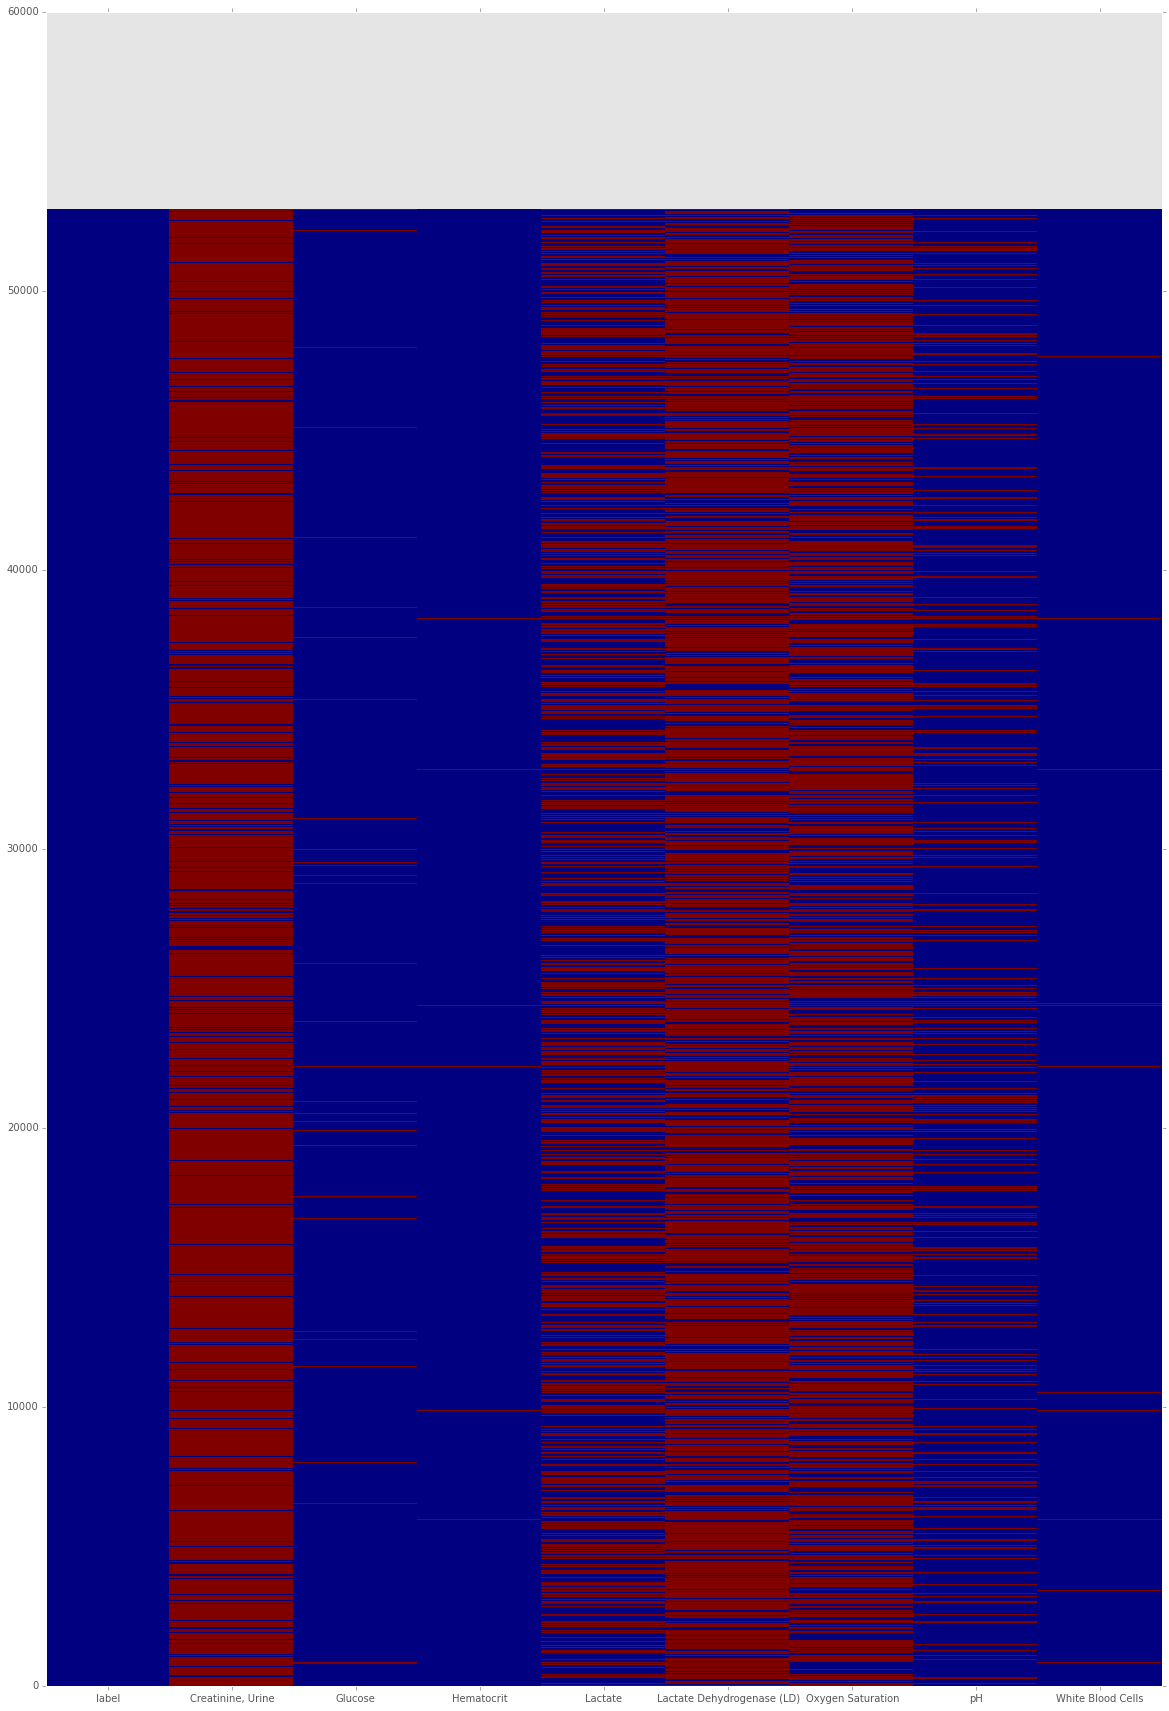

'\n# DISPLAY COLORMAP OF THE NUMBER OF SAMPLES FOR EACH VARIABLE\n#header = num_samps_df.replace(np.nan, -100, inplace = False)\nplt.figure(figsize = (20,30))\nplt.pcolor(num_samps_df.dropna())\nplt.xticks(np.arange(0.5, len(num_samps_df.columns),1), num_samps_df.columns)\nplt.show()\n'

In [29]:

# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A NEGATIVE VALUE MAKES MISSING DATA APPEAR DARK BLUE

missing = num_samps_df.copy()
for col in missing.columns:
        missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
plt.figure(figsize= (20,30))
plt.pcolor(missing)
#plt.yticks(np.arange(0.5, len(header.index), 1), header.index)
plt.xticks(np.arange(0.5, len(missing.columns), 1), missing.columns)
plt.show()
plt.close()

'''
# DISPLAY COLORMAP OF THE NUMBER OF SAMPLES FOR EACH VARIABLE
#header = num_samps_df.replace(np.nan, -100, inplace = False)
plt.figure(figsize = (20,30))
plt.pcolor(num_samps_df.dropna())
plt.xticks(np.arange(0.5, len(num_samps_df.columns),1), num_samps_df.columns)
plt.show()
'''


## Calculating values from original data including mean, std, delta etc. 


In [139]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.



# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

# CREATE DICTS OF VARIABLE NAMES WITH MEASUREMENT INDICATOR APPENDED AS KEYS AND 
# LABELS AS ENTRIES
first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

# CREATE LIST OF NAMES_DICTS FOR EASY TRAVERSAL / ITERATION AND FOR ZIPPING INTO DICTIONARY
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# CREATE LIST FOR ZIPPING INTO DICTIONARY THE MEASUREMENT TYPE AND THE CORRESPONDING NAMES_DICT
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# CREATE DICTIONARY WHERE KEY IS THE TYPE OF CALCULATION AND THE VALUE IS THE NAMES_DICT 
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

# ITERATING THROUGH THE VARIABLES, CALCULATING MEANS, MEDIANS, STD, SKEWNESS, MIN AND MAX'S FOR EACH ITERATION
# VARIABLES WITH TOO FEW MEASUREMENTS TO CALCULATE THINGS LIKE STD WILL BE AUTOMATICALLY ASSIGNED 'NaN' VALUE
print "Creating data frames for each summary statistic for each time course variable"
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: int(1) if 'abnormal' in x.values else int(0)))
              
        elif calc_key == 'slope':
            time_last = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print "need to add code for calculating {}".format(calc_key)
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = data.groupby('icustay_id').gender.first()

print "complete"

Creating data frames for each summary statistic for each time course variable
complete


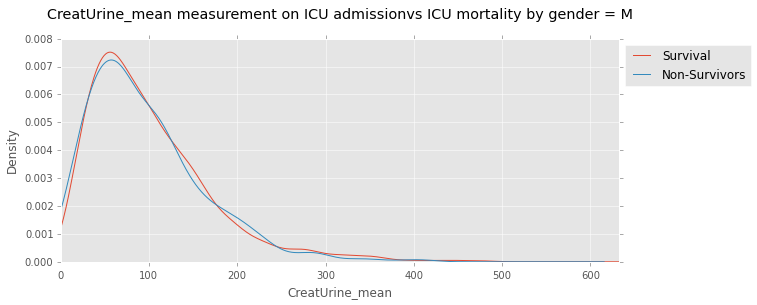

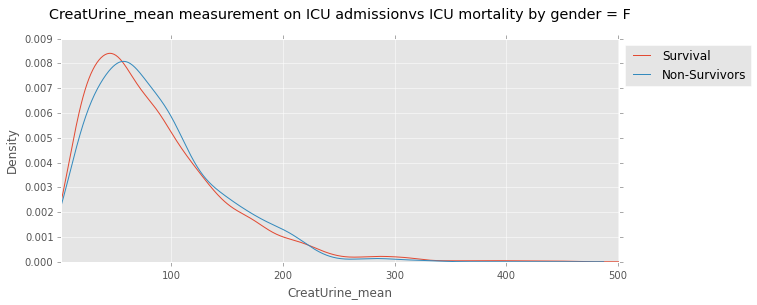

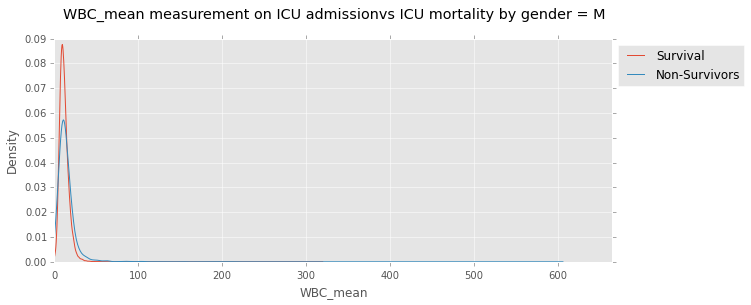

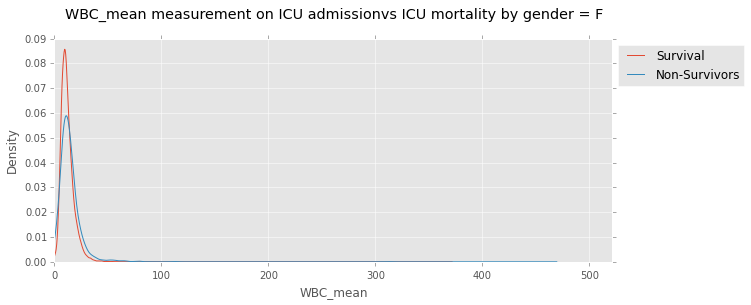

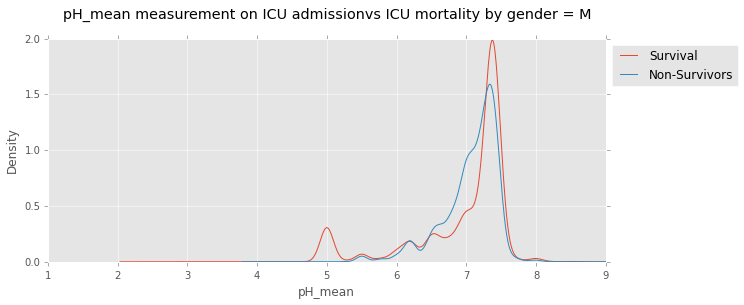

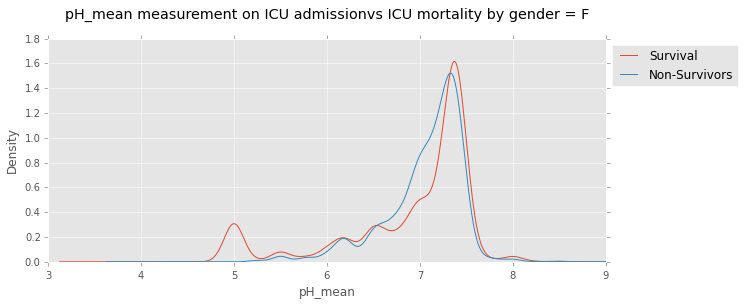

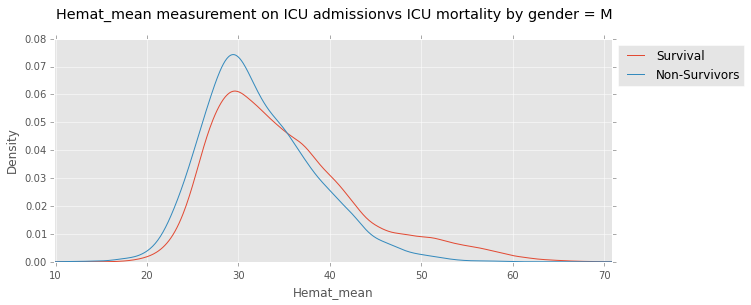

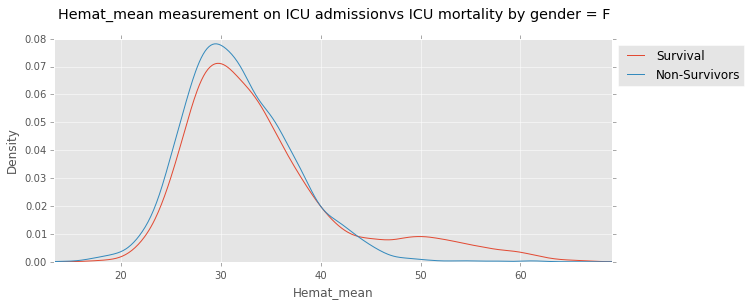

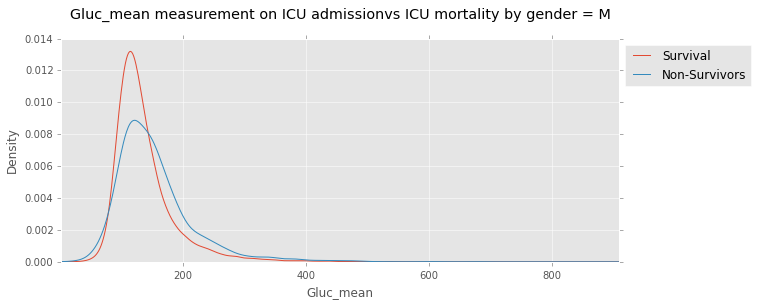

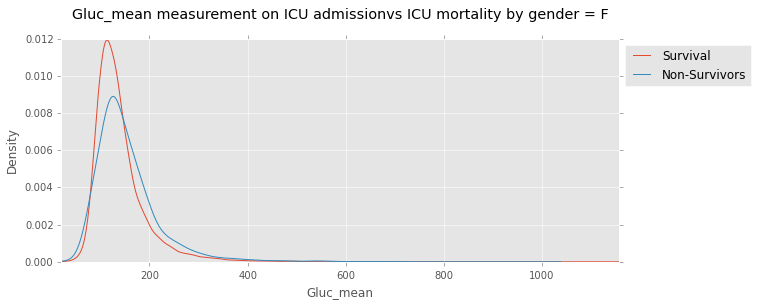

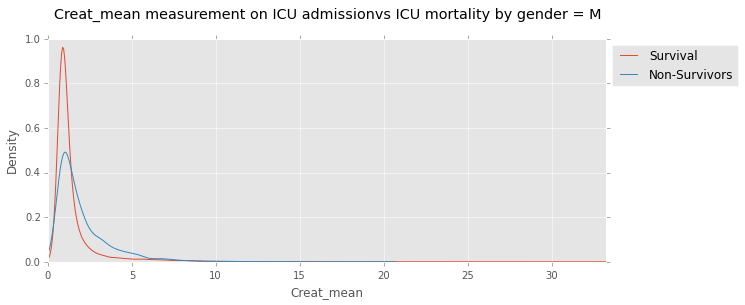

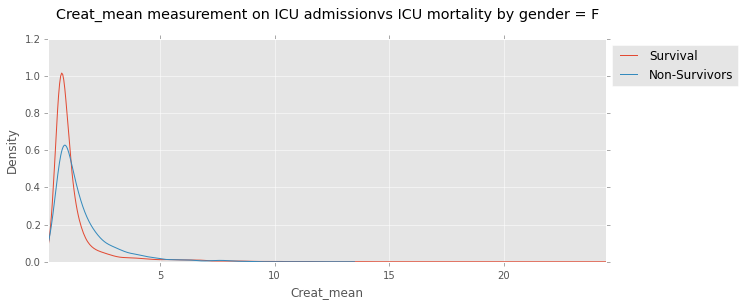

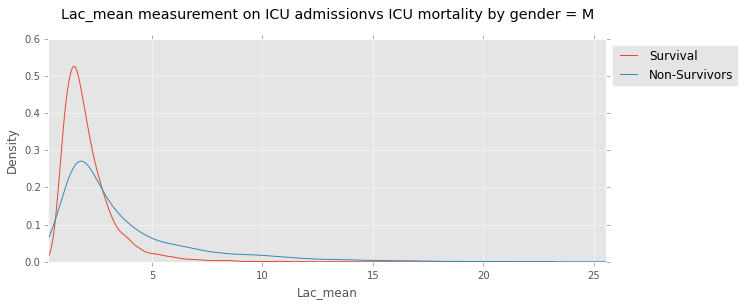

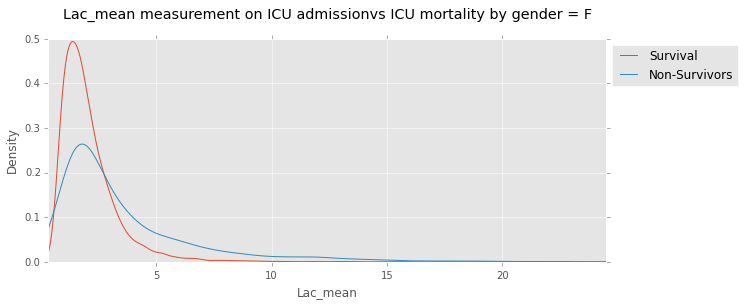

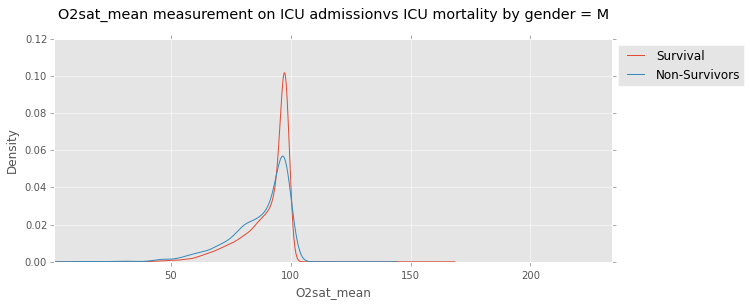

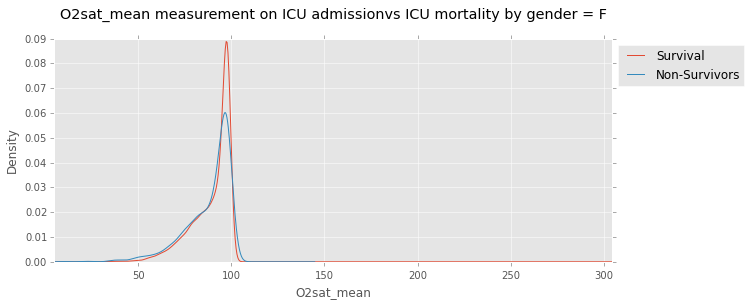

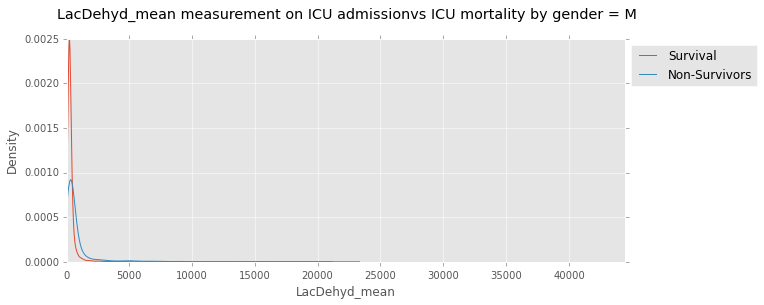

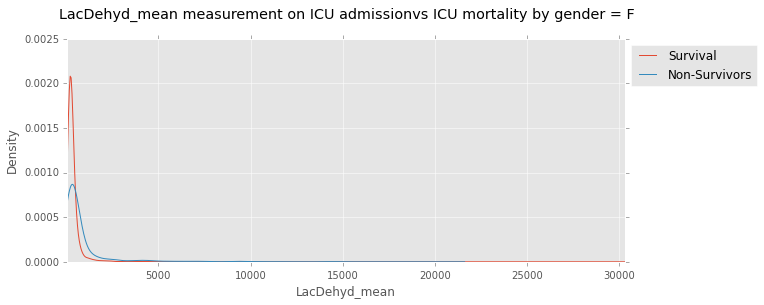

In [31]:
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

In [144]:
calc_dict['abnflag']['CreatUrine_abnflag'].dtypes

CreatUrine_abnflag       int64
hospital_expire_flag     int64
gender                  object
dtype: object

In [145]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAME
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
data3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print "merging {} dataframe".format(calc_key)
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        data3 = data3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(data3.columns)
        newcols.pop()
        newcols.append(col_key)
        data3.columns = newcols
display(data3.shape)
display(data3.head())
display(data3.dtypes)
        
# OLD CODE


merging std dataframe
merging med dataframe
merging abnflag dataframe
merging slope dataframe
merging min dataframe
merging max dataframe
merging skew dataframe
merging delta dataframe
merging first dataframe
merging mean dataframe


(59798, 93)

,subject_id,gender,hospital_expire_flag,pH_std,Hemat_std,Gluc_std,CreatUrine_std,O2sat_std,WBC_std,LacDehyd_std,...,Creat_first,CreatUrine_mean,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,55973,F,0,1.067085,1.767767,NaN,NaN,5.656854,0.070711,NaN,...,2.7,NaN,2.850000,6.908000,24.850000,87.000000,2.700000,1.400000,92.0,209.0
200003,27513,M,0,0.979600,2.059935,35.501174,NaN,1.414214,15.841191,17.67767,...,0.9,NaN,32.966667,6.998333,33.433333,119.666667,0.866667,3.933333,97.0,203.5
200006,10950,M,0,NaN,6.269237,109.601551,NaN,NaN,6.091251,NaN,...,1.1,NaN,7.666667,6.000000,28.666667,148.500000,0.950000,3.100000,NaN,NaN
200007,20707,M,0,NaN,4.454773,30.512293,NaN,NaN,2.333452,NaN,...,0.9,NaN,9.550000,NaN,41.250000,242.000000,0.833333,NaN,NaN,NaN
200009,29904,F,0,0.078606,1.609200,NaN,NaN,NaN,1.604265,NaN,...,0.5,NaN,12.416667,7.393000,29.542857,91.000000,0.500000,2.000000,98.0,NaN


subject_id                int64
gender                   object
hospital_expire_flag      int64
pH_std                  float64
Hemat_std               float64
Gluc_std                float64
CreatUrine_std          float64
O2sat_std               float64
WBC_std                 float64
LacDehyd_std            float64
Lac_std                 float64
Creat_std               float64
WBC_med                 float64
O2sat_med               float64
Gluc_med                float64
Hemat_med               float64
Lac_med                 float64
Creat_med               float64
LacDehyd_med            float64
CreatUrine_med          float64
pH_med                  float64
Hemat_abnflag           float64
Gluc_abnflag            float64
WBC_abnflag             float64
pH_abnflag              float64
LacDehyd_abnflag        float64
O2sat_abnflag           float64
CreatUrine_abnflag      float64
Lac_abnflag             float64
Creat_abnflag           float64
                         ...   
Lac_skew

In [148]:
data3.columns[:4]

Index([u'subject_id', u'gender', u'hospital_expire_flag', u'pH_std'], dtype='object')

ValueError: Cannot convert NA to integer

In [33]:
[x for x in data3.columns if 'first' in x] 
#display(cols)

['icustay_id',
 'subject_id',
 'gender',
 'label',
 'charttime',
 'valuenum',
 'flag',
 'hospital_expire_flag']

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1147

,CreatUrine_first,Creat_first,Gluc_first,Hemat_first,LacDehyd_first,Lac_first,O2sat_first,WBC_first,pH_first
CreatUrine_first,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_first,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_first,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_first,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_first,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_first,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_first,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_first,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_first,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


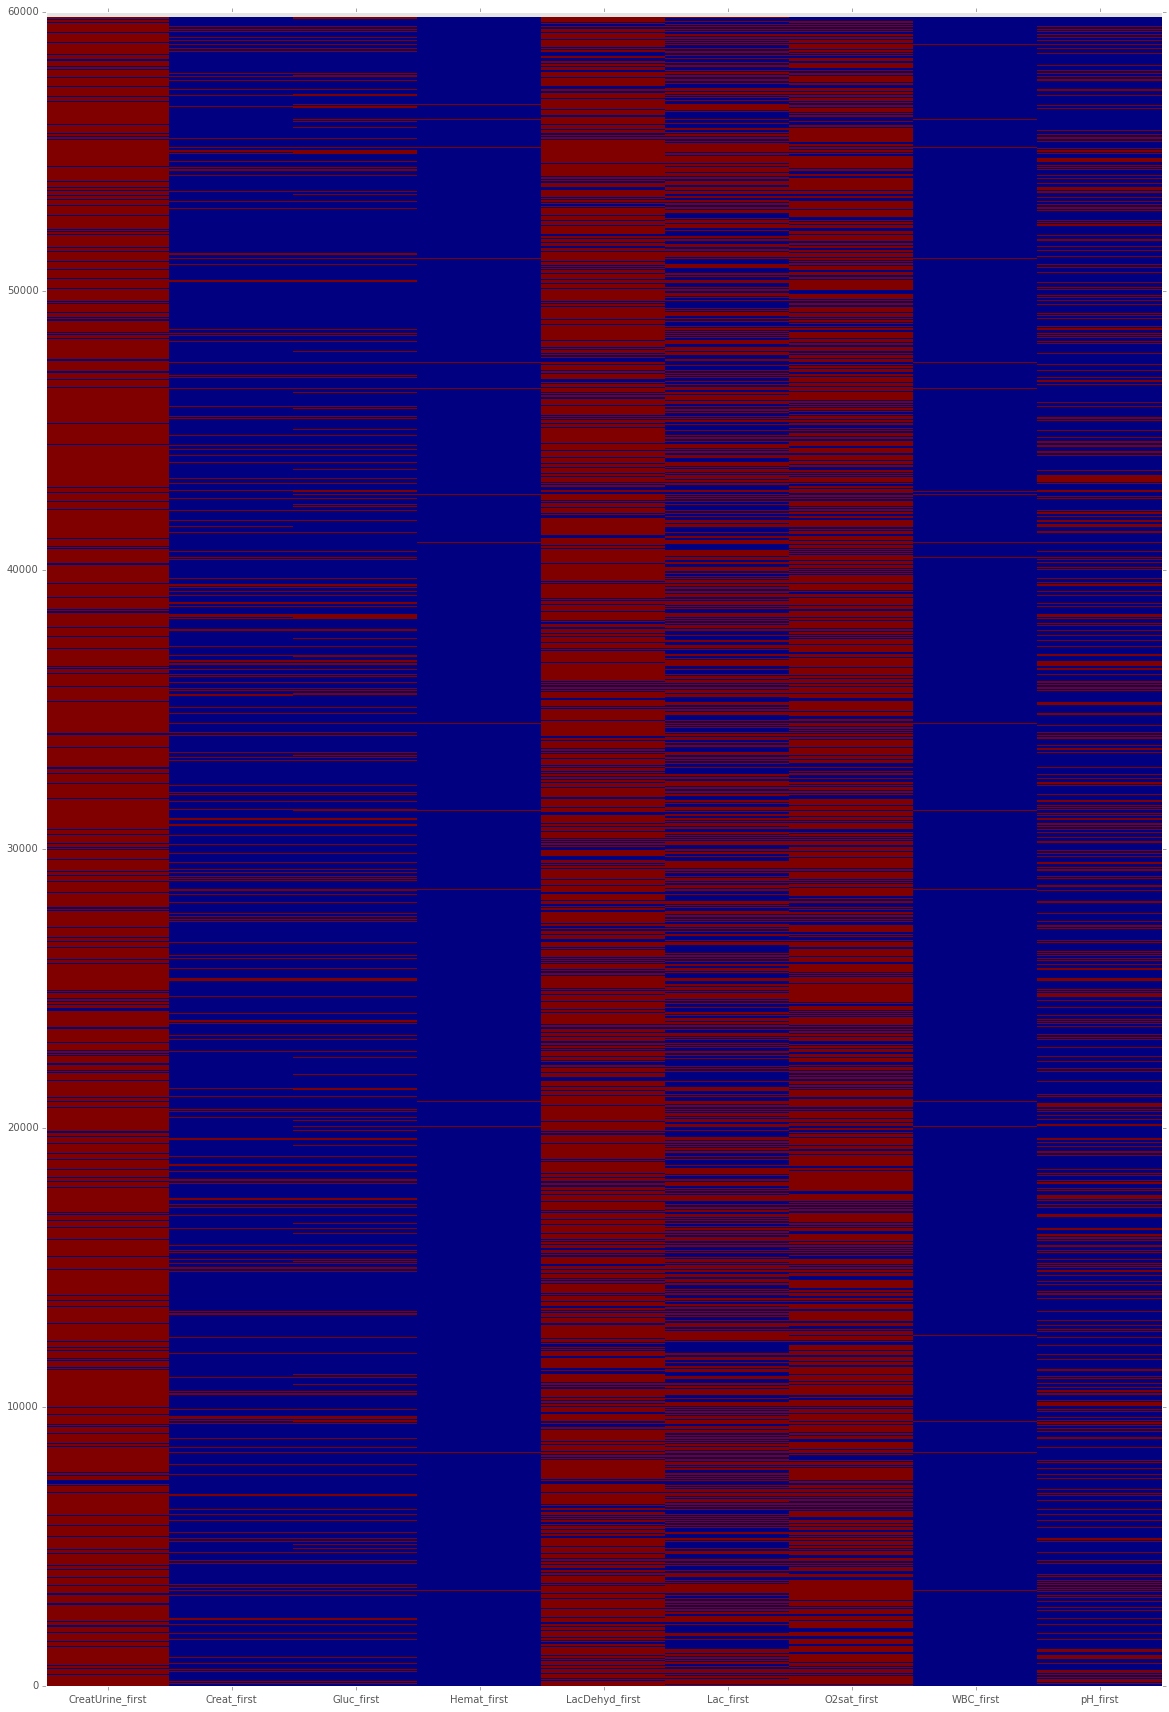

1147

,CreatUrine_mean,Creat_mean,Gluc_mean,Hemat_mean,LacDehyd_mean,Lac_mean,O2sat_mean,WBC_mean,pH_mean
CreatUrine_mean,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_mean,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_mean,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_mean,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_mean,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_mean,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_mean,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_mean,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_mean,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


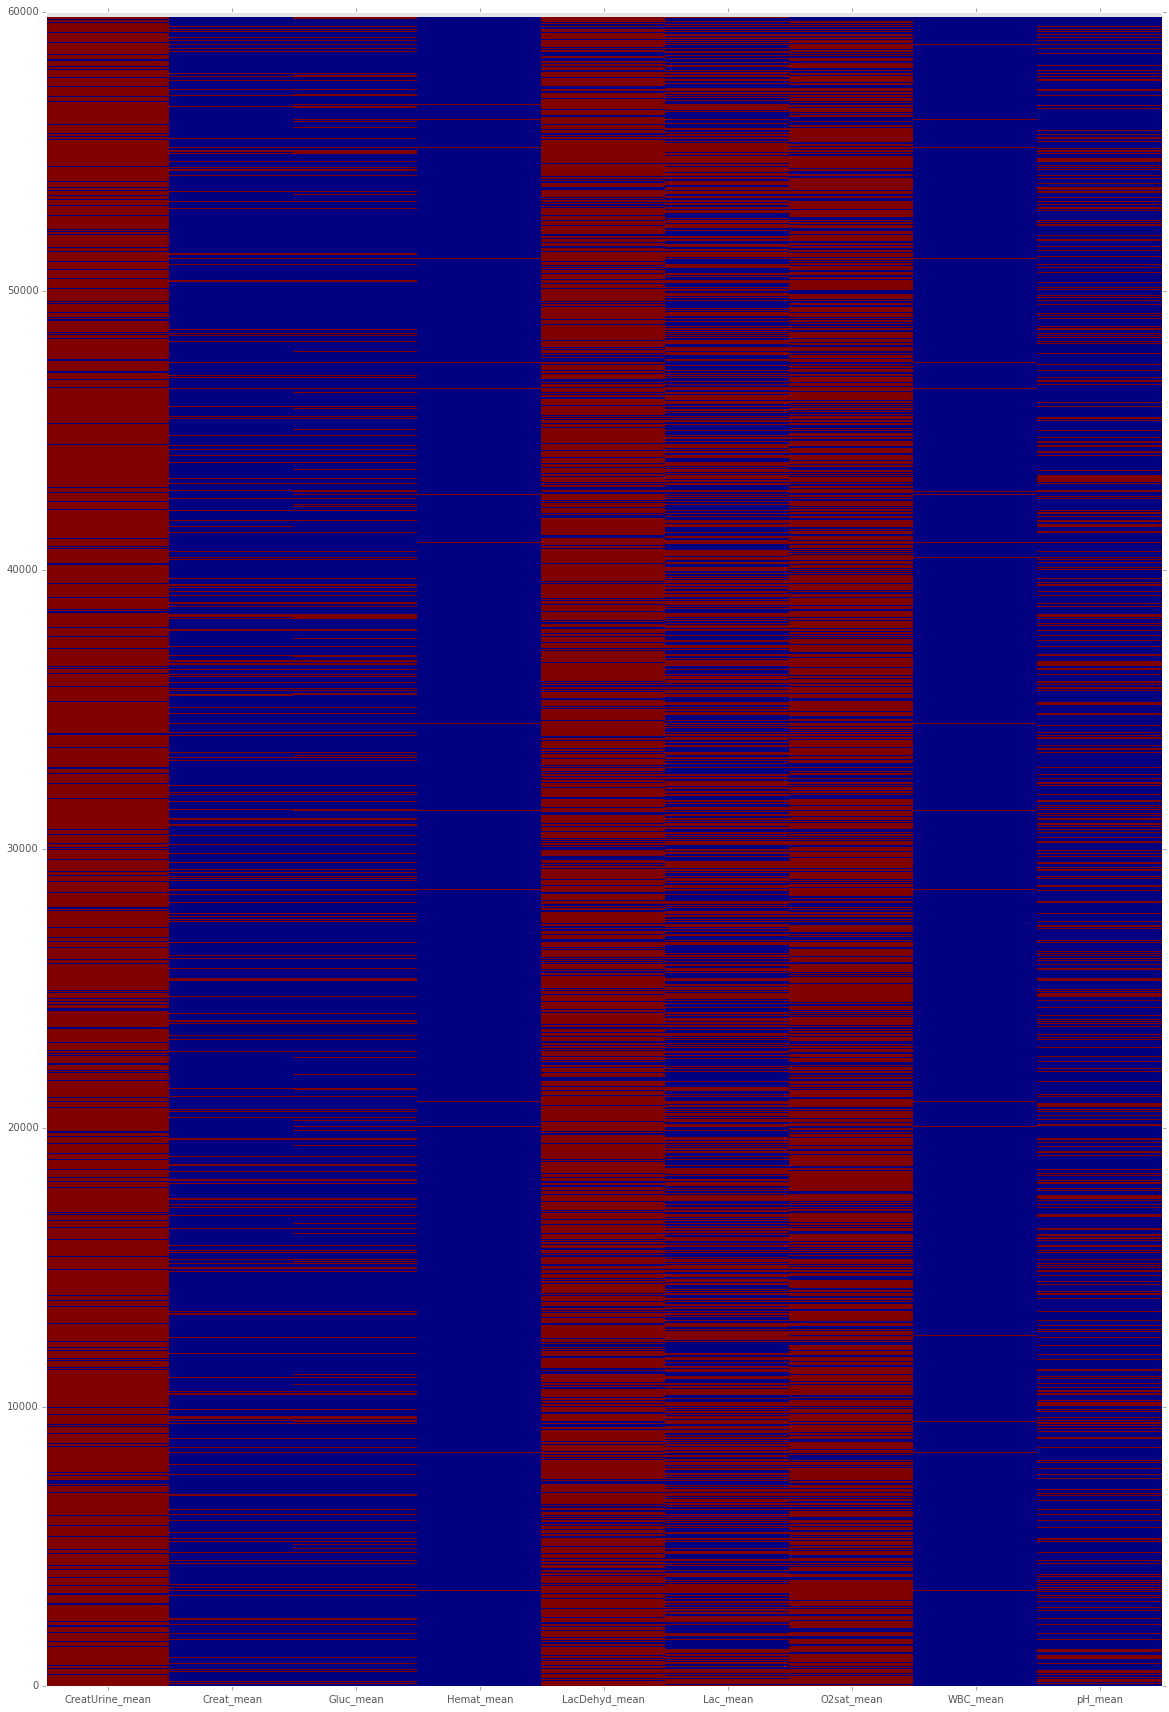

1147

,CreatUrine_med,Creat_med,Gluc_med,Hemat_med,LacDehyd_med,Lac_med,O2sat_med,WBC_med,pH_med
CreatUrine_med,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_med,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_med,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_med,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_med,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_med,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_med,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_med,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_med,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


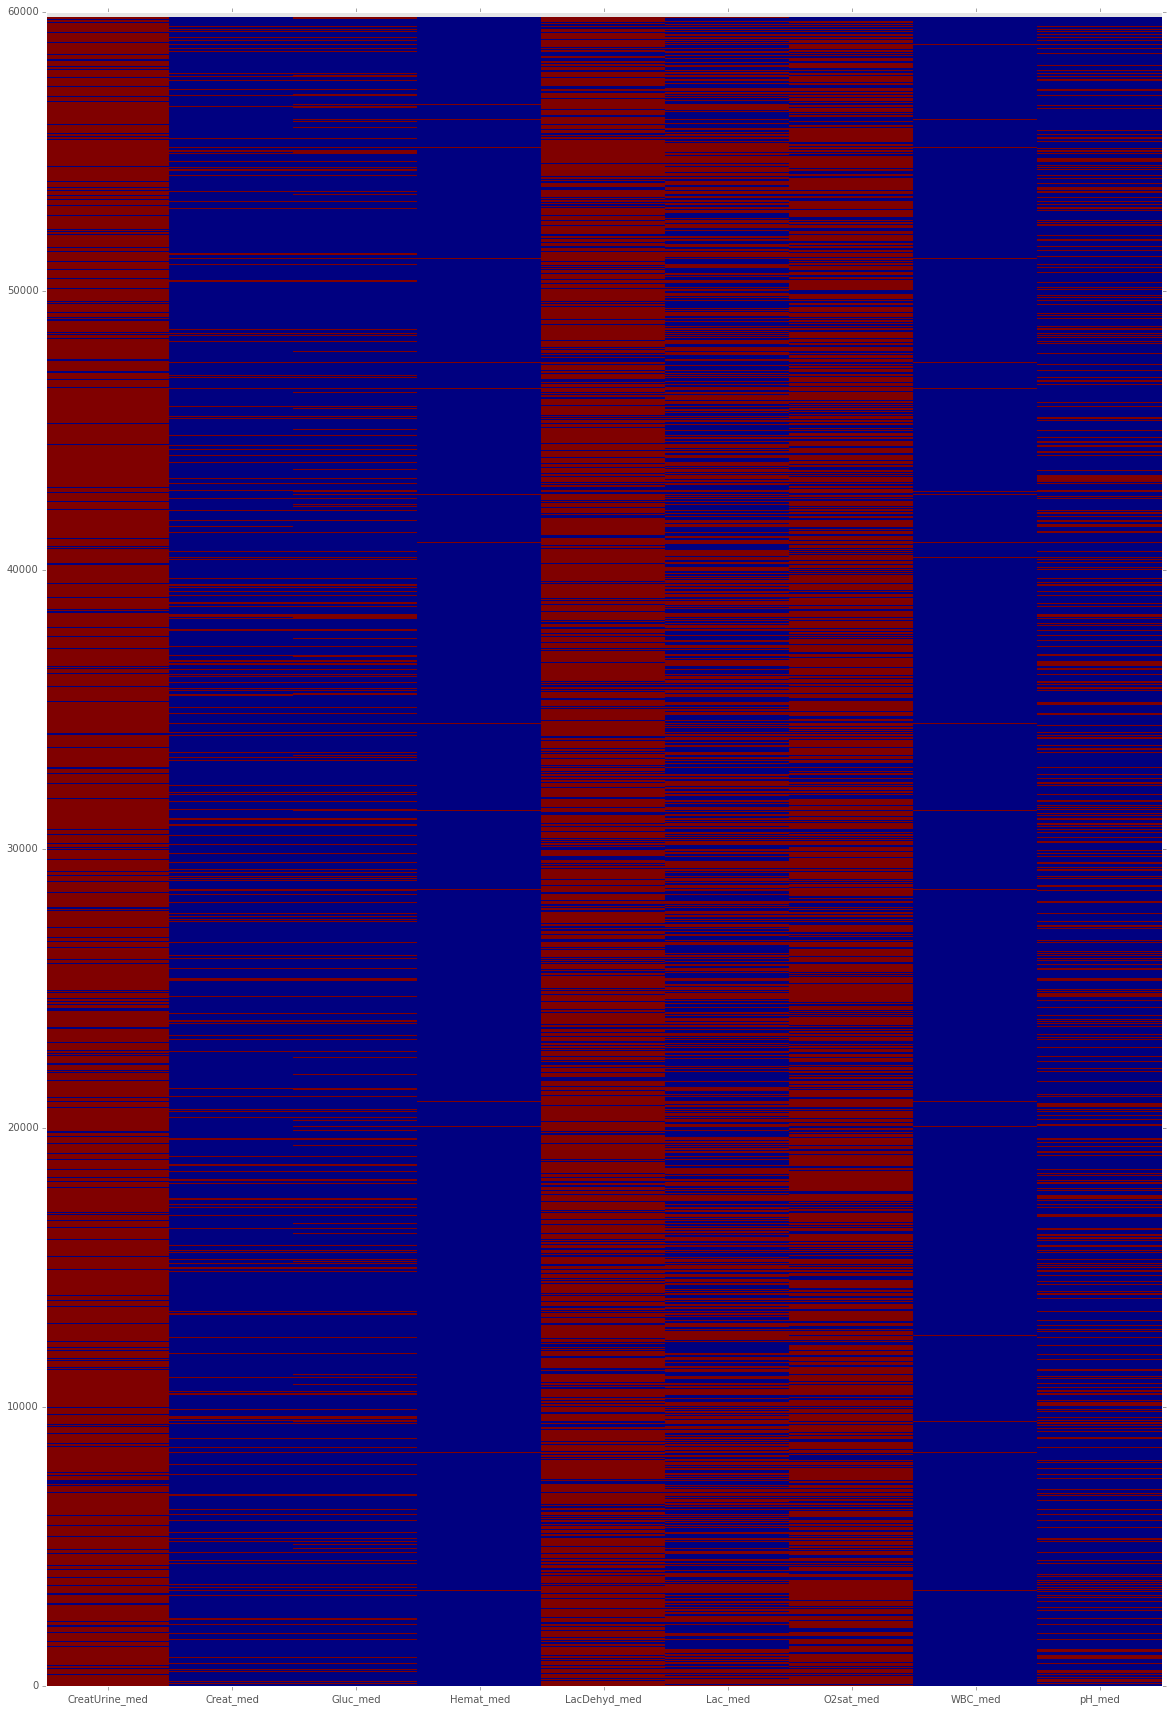

22072

,Creat_std,Gluc_std,Hemat_std,WBC_std,pH_std
Creat_std,1.000000,0.769048,0.759426,0.781784,NaN
Gluc_std,0.769048,1.000000,0.591802,0.627076,NaN
Hemat_std,0.759426,0.591802,1.000000,0.866219,NaN
WBC_std,0.781784,0.627076,0.866219,1.000000,NaN
pH_std,NaN,NaN,NaN,NaN,1.0


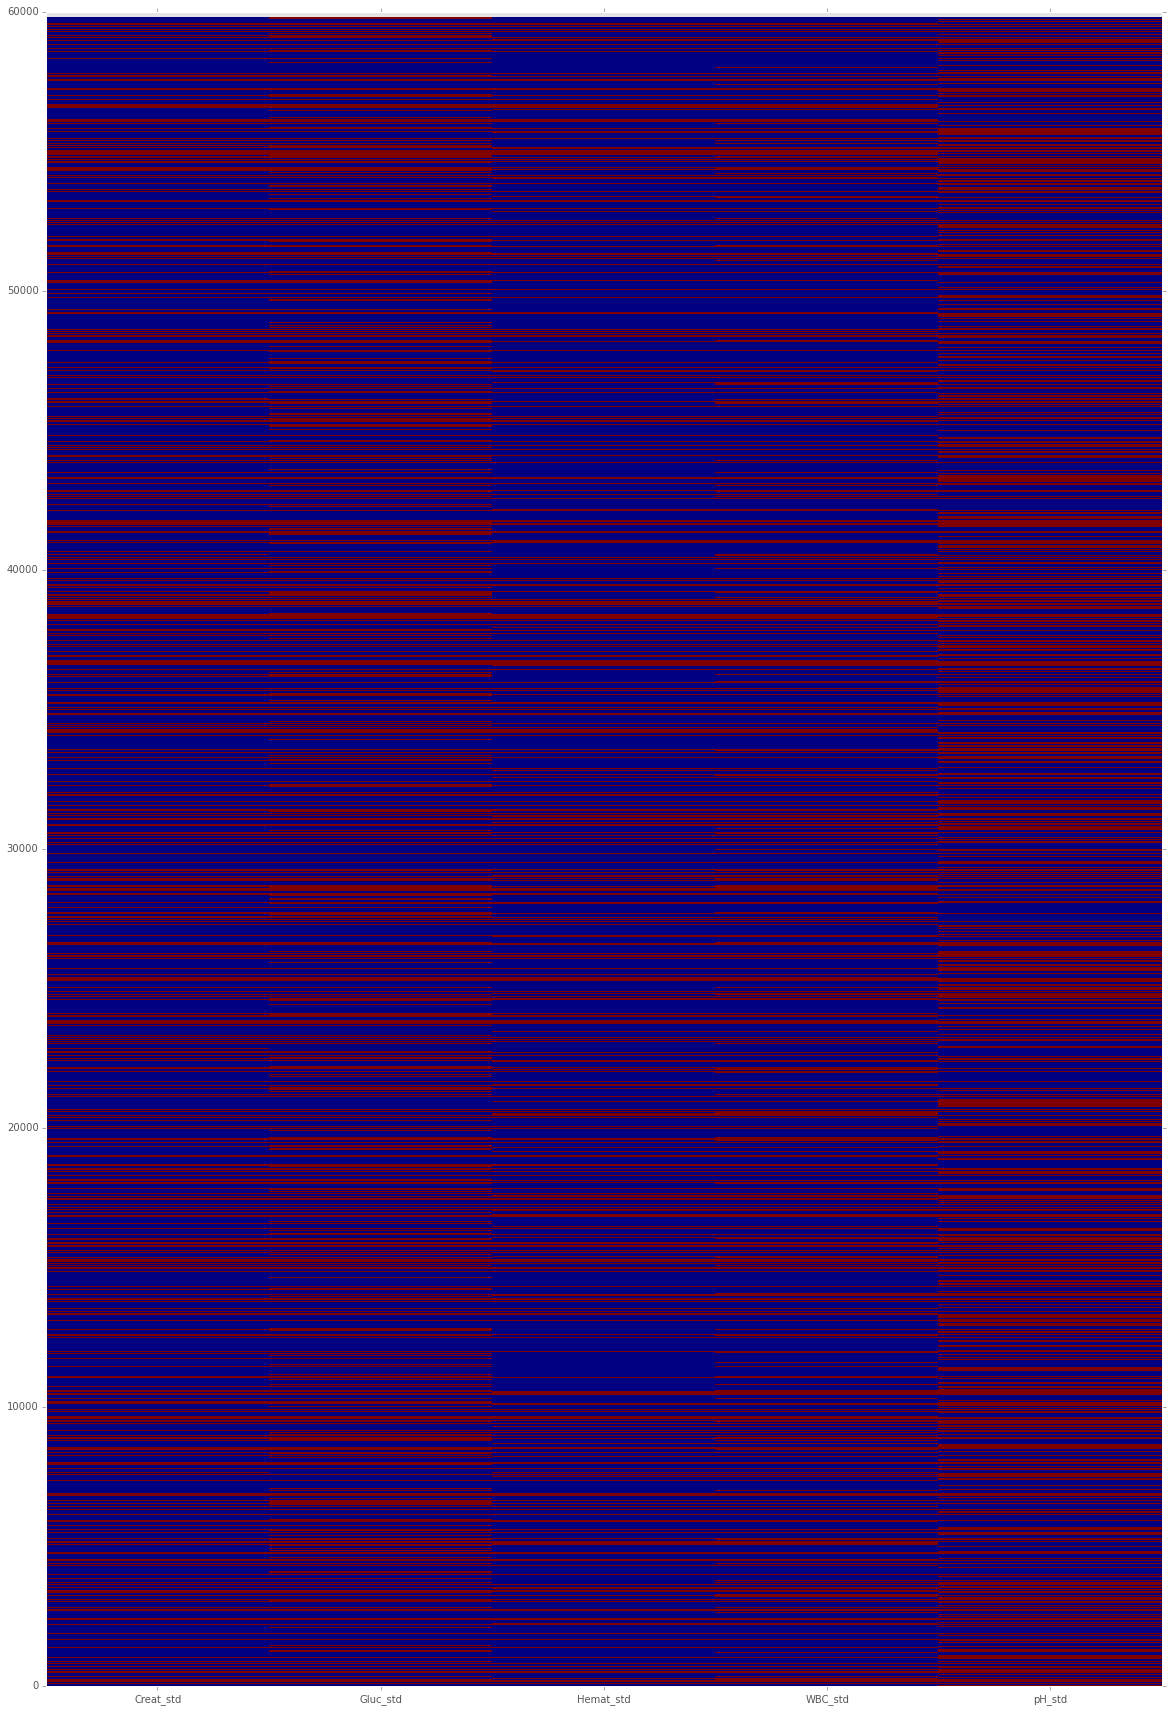

7228

,Creat_skew,Gluc_skew,Hemat_skew,WBC_skew,pH_skew
Creat_skew,1.000000,0.858799,0.449776,0.535654,NaN
Gluc_skew,0.858799,1.000000,NaN,0.466774,NaN
Hemat_skew,0.449776,NaN,1.000000,0.735728,NaN
WBC_skew,0.535654,0.466774,0.735728,1.000000,NaN
pH_skew,NaN,NaN,NaN,NaN,1.0


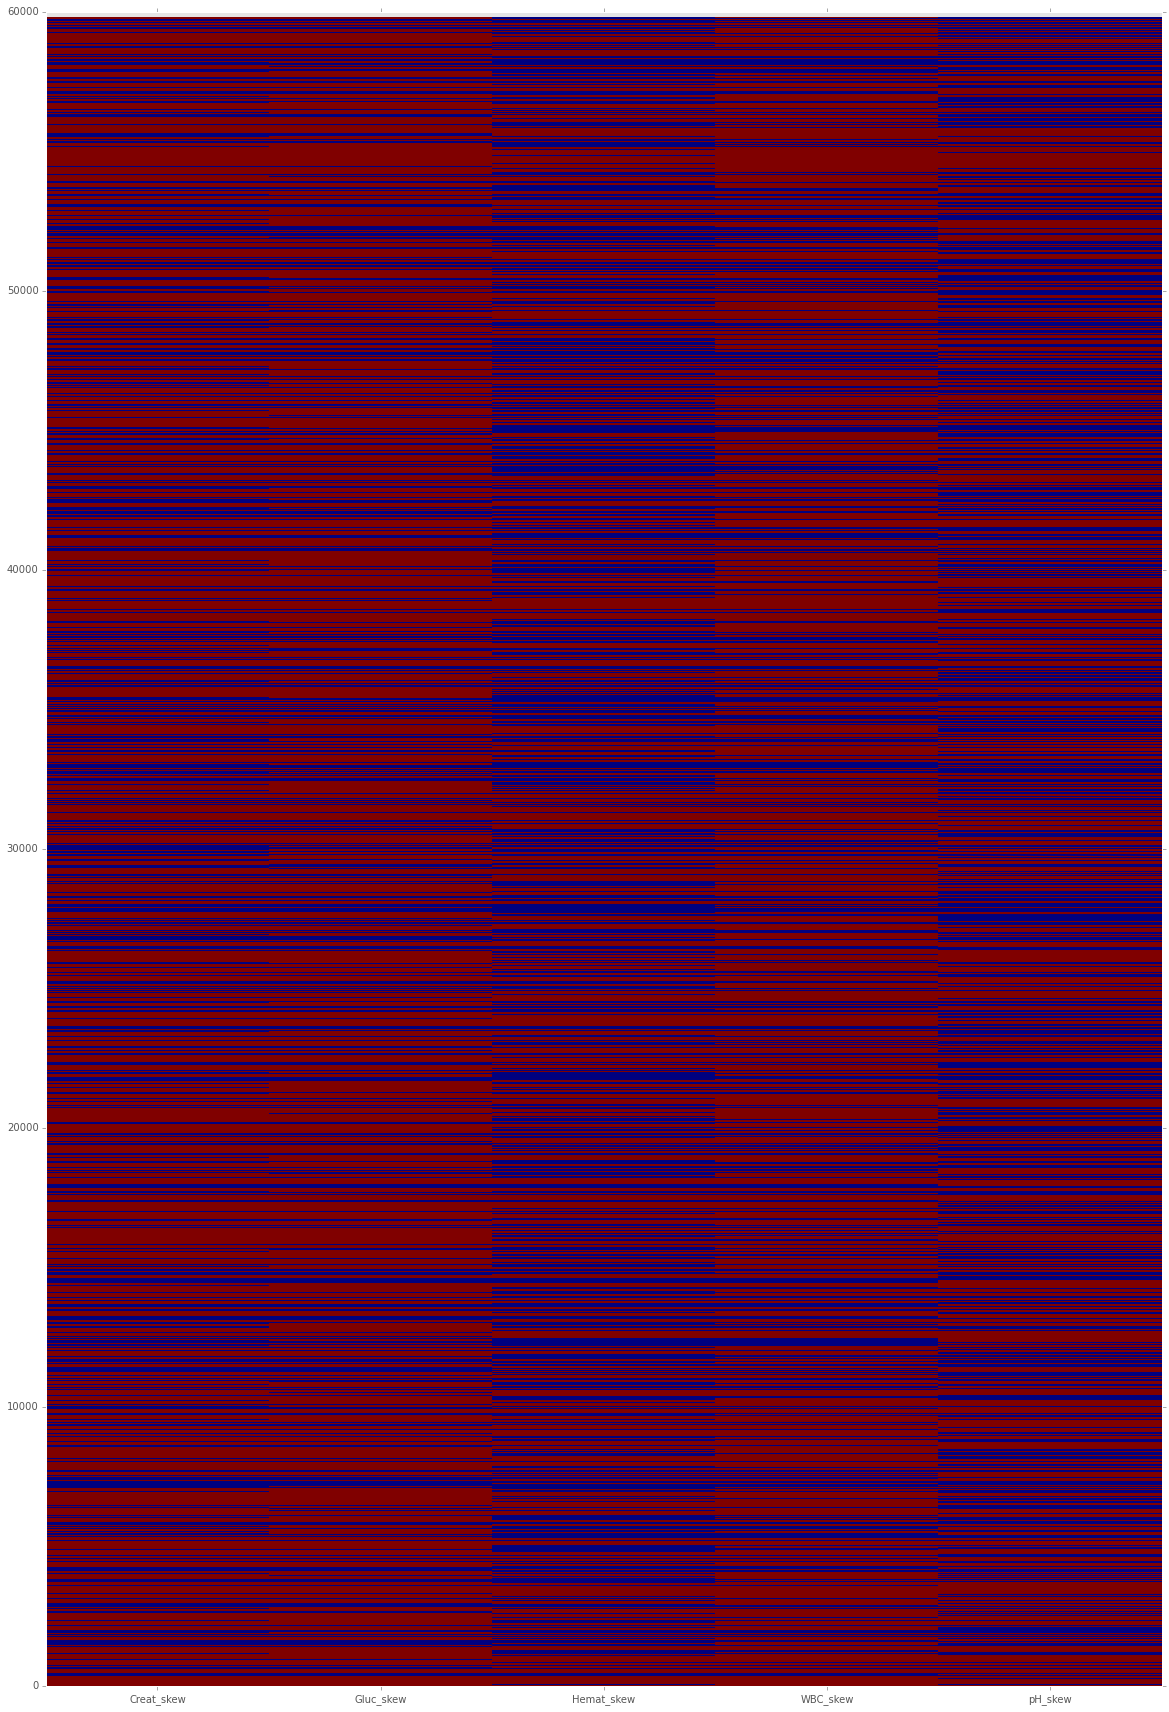

1147

,CreatUrine_min,Creat_min,Gluc_min,Hemat_min,LacDehyd_min,Lac_min,O2sat_min,WBC_min,pH_min
CreatUrine_min,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_min,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_min,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_min,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_min,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_min,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_min,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_min,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


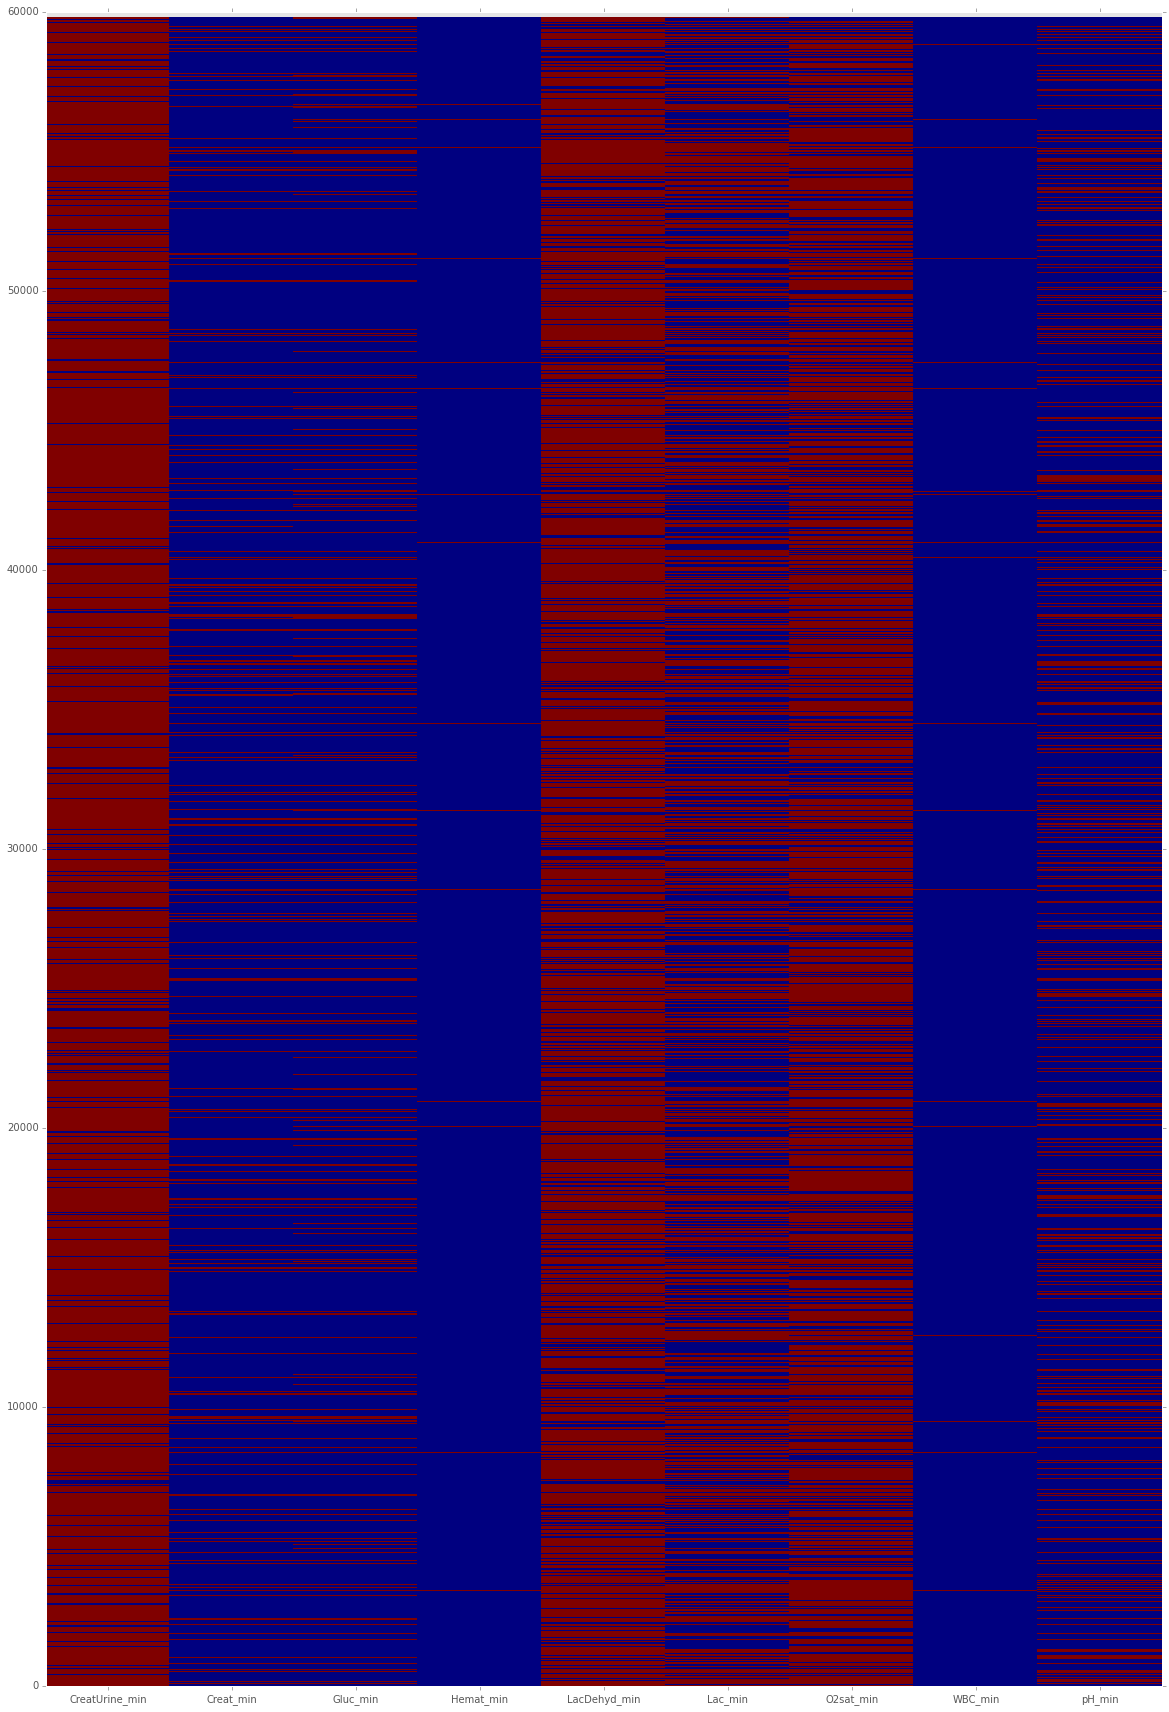

1147

,CreatUrine_max,Creat_max,Gluc_max,Hemat_max,LacDehyd_max,Lac_max,O2sat_max,WBC_max,pH_max
CreatUrine_max,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_max,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_max,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_max,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_max,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_max,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_max,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_max,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_max,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


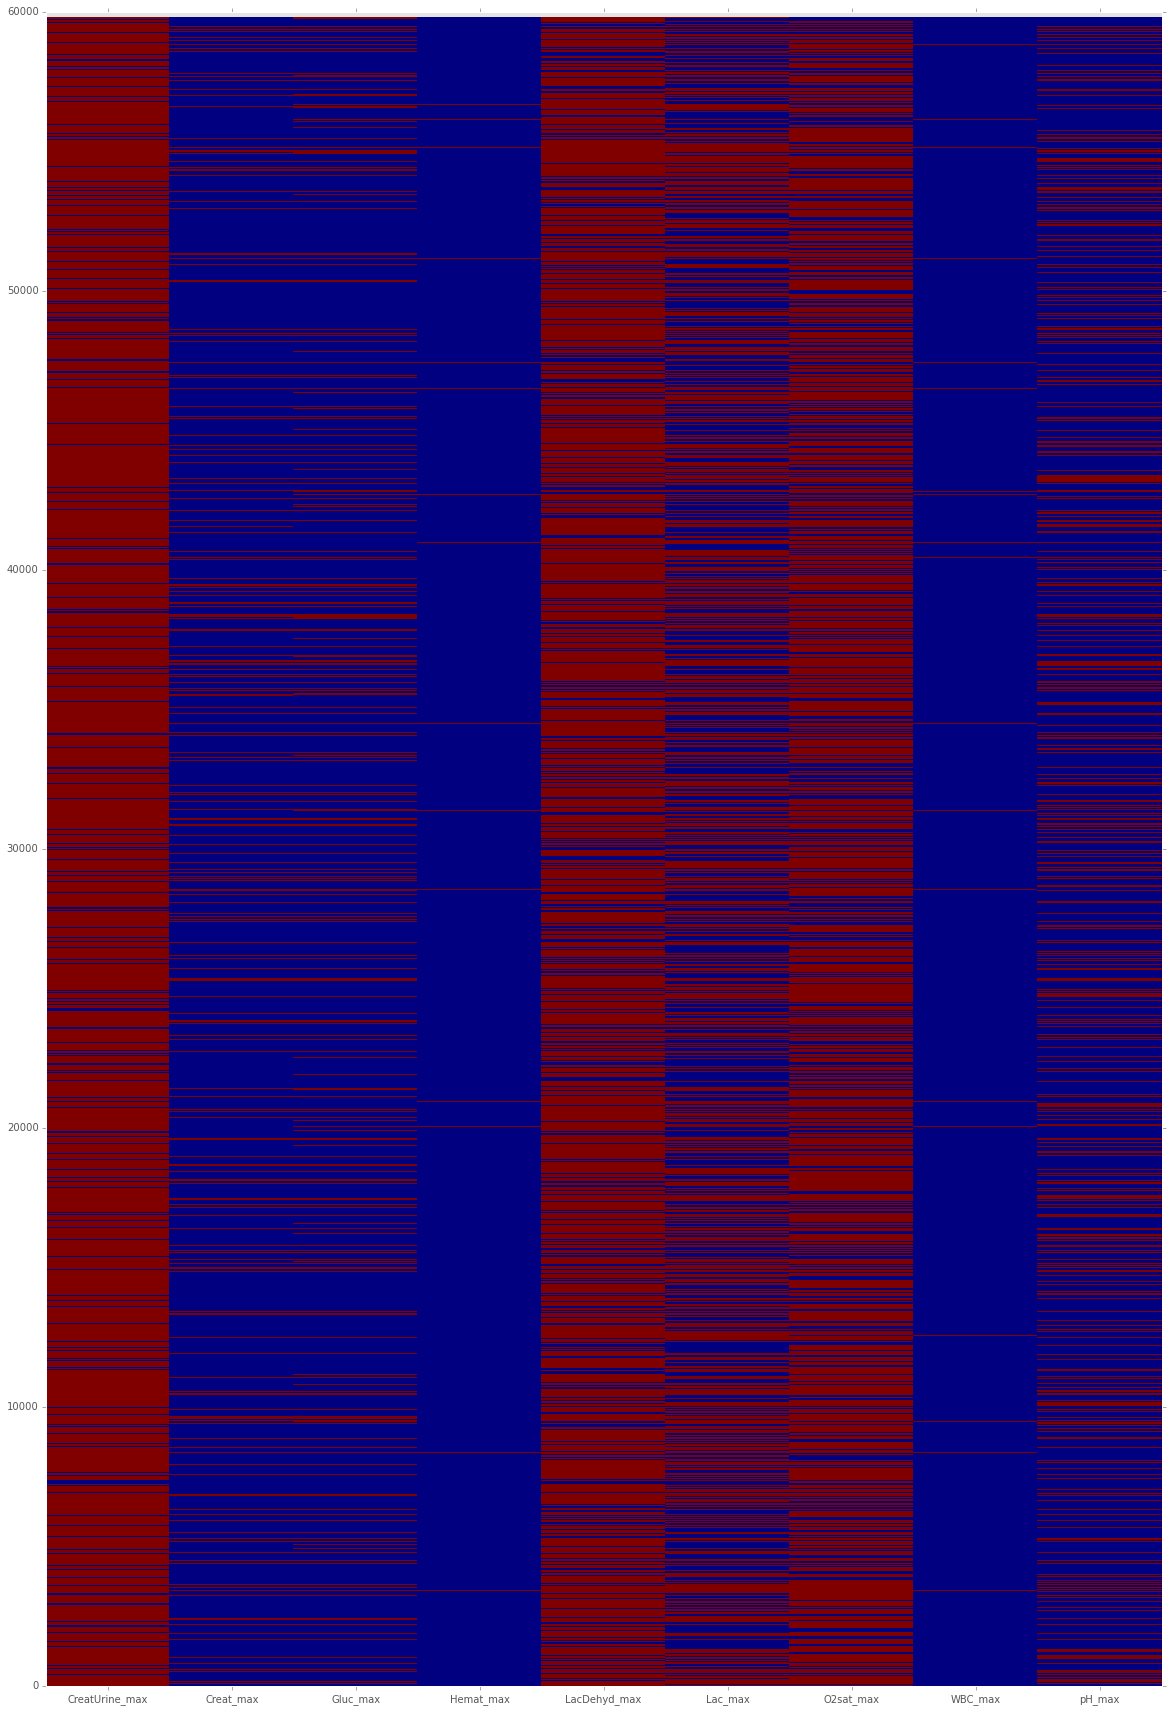

22075

,Creat_slope,Gluc_slope,Hemat_slope,WBC_slope,pH_slope
Creat_slope,1.000000,0.769144,0.759212,0.781796,NaN
Gluc_slope,0.769144,1.000000,0.591647,0.627157,NaN
Hemat_slope,0.759212,0.591647,1.000000,0.866416,NaN
WBC_slope,0.781796,0.627157,0.866416,1.000000,NaN
pH_slope,NaN,NaN,NaN,NaN,1.0


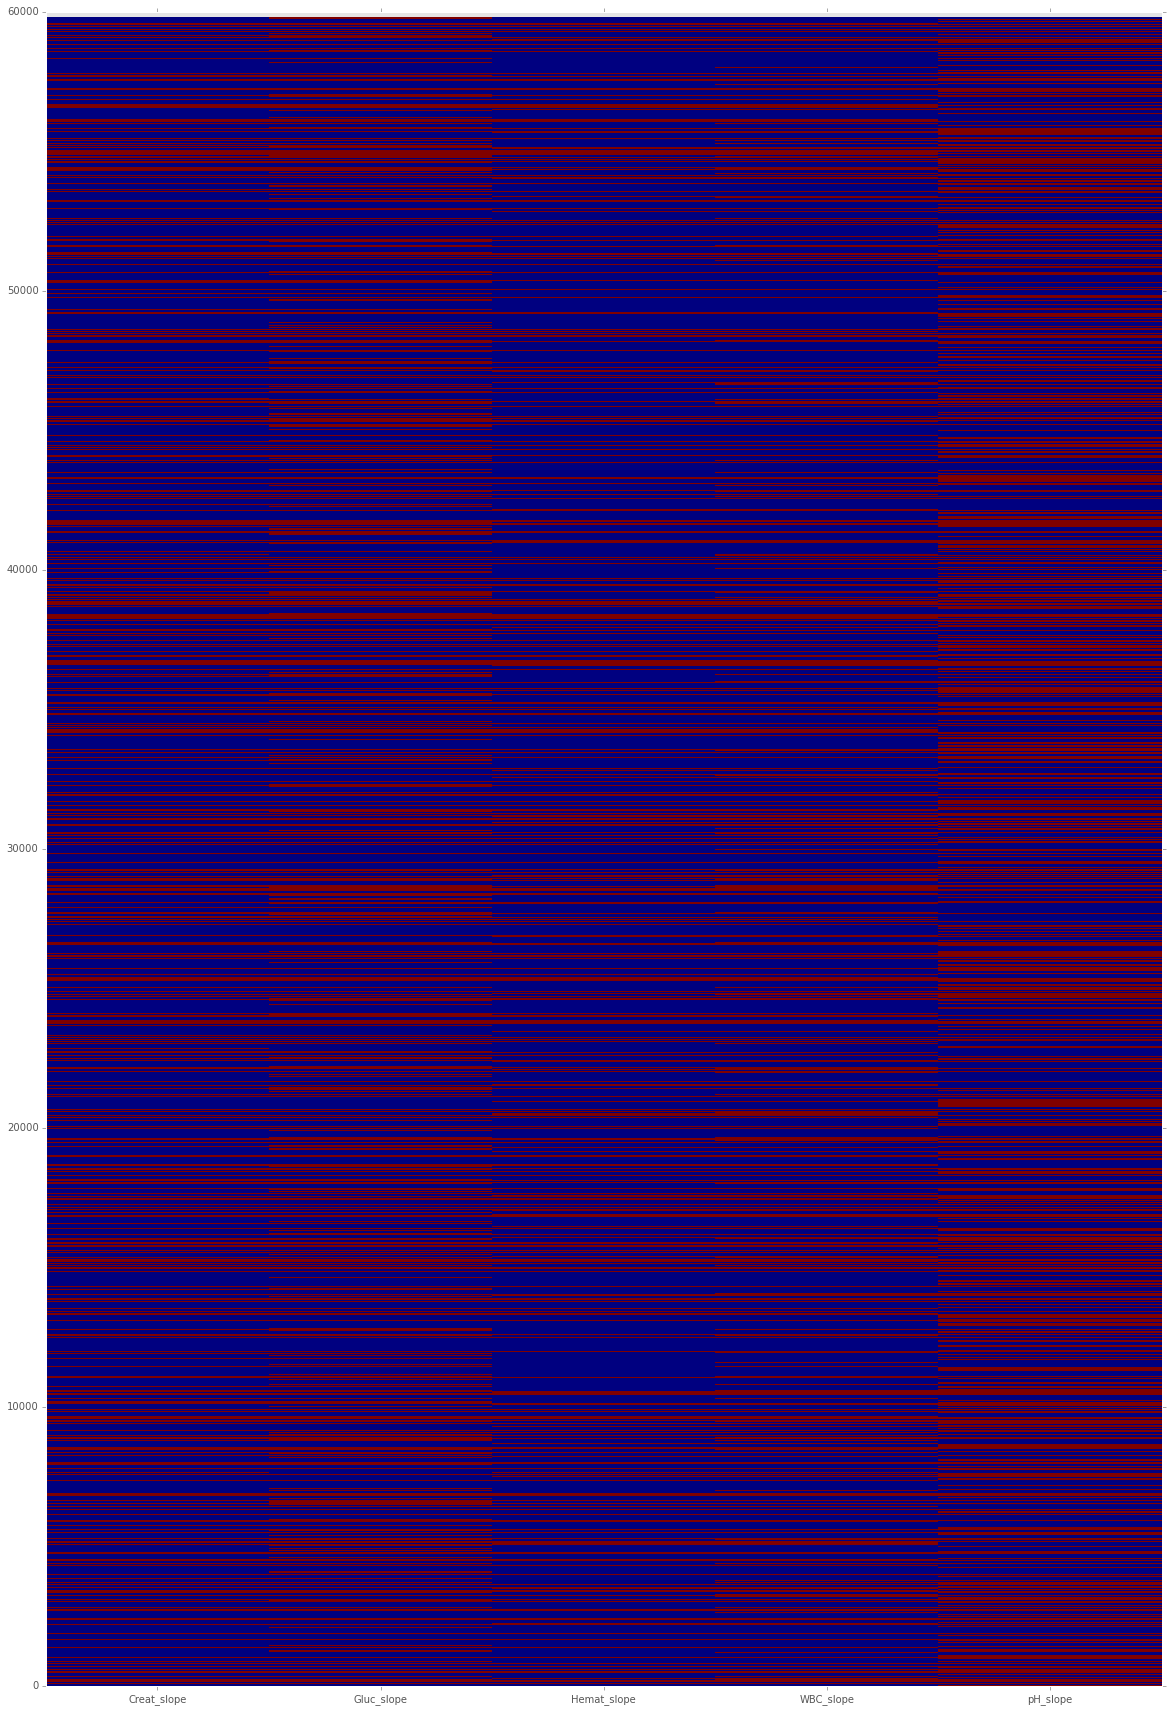

1147

,CreatUrine_delta,Creat_delta,Gluc_delta,Hemat_delta,LacDehyd_delta,Lac_delta,O2sat_delta,WBC_delta,pH_delta
CreatUrine_delta,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_delta,NaN,1.000000,0.895608,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_delta,NaN,0.895608,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_delta,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.77492,NaN
LacDehyd_delta,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_delta,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496482
O2sat_delta,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_delta,NaN,NaN,NaN,0.77492,NaN,NaN,NaN,1.00000,NaN
pH_delta,NaN,NaN,NaN,NaN,NaN,0.496482,NaN,NaN,1.000000


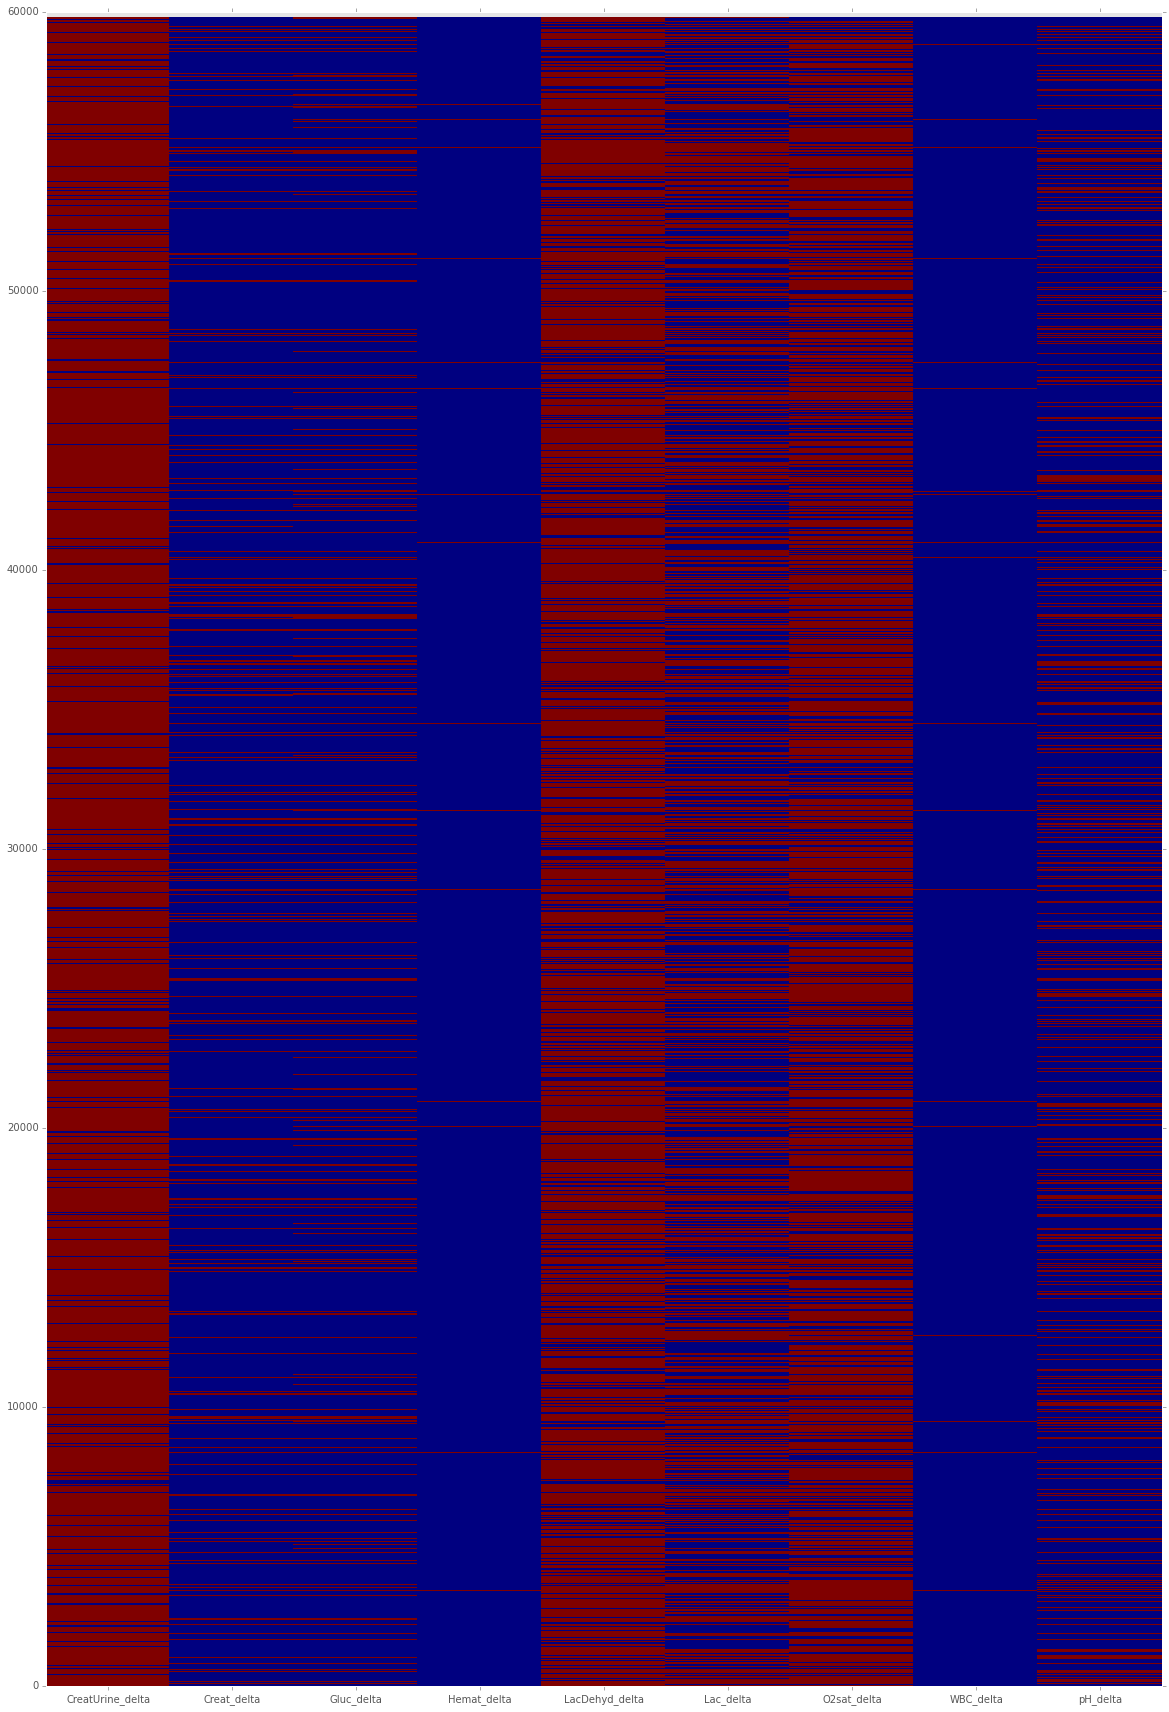

1148

,CreatUrine_abnflag,Creat_abnflag,Gluc_abnflag,Hemat_abnflag,LacDehyd_abnflag,Lac_abnflag,O2sat_abnflag,WBC_abnflag,pH_abnflag
CreatUrine_abnflag,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Creat_abnflag,NaN,1.000000,0.895661,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_abnflag,NaN,0.895661,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_abnflag,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.777431,NaN
LacDehyd_abnflag,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Lac_abnflag,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.496561
O2sat_abnflag,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
WBC_abnflag,NaN,NaN,NaN,0.777431,NaN,NaN,NaN,1.000000,NaN
pH_abnflag,NaN,NaN,NaN,NaN,NaN,0.496561,NaN,NaN,1.000000


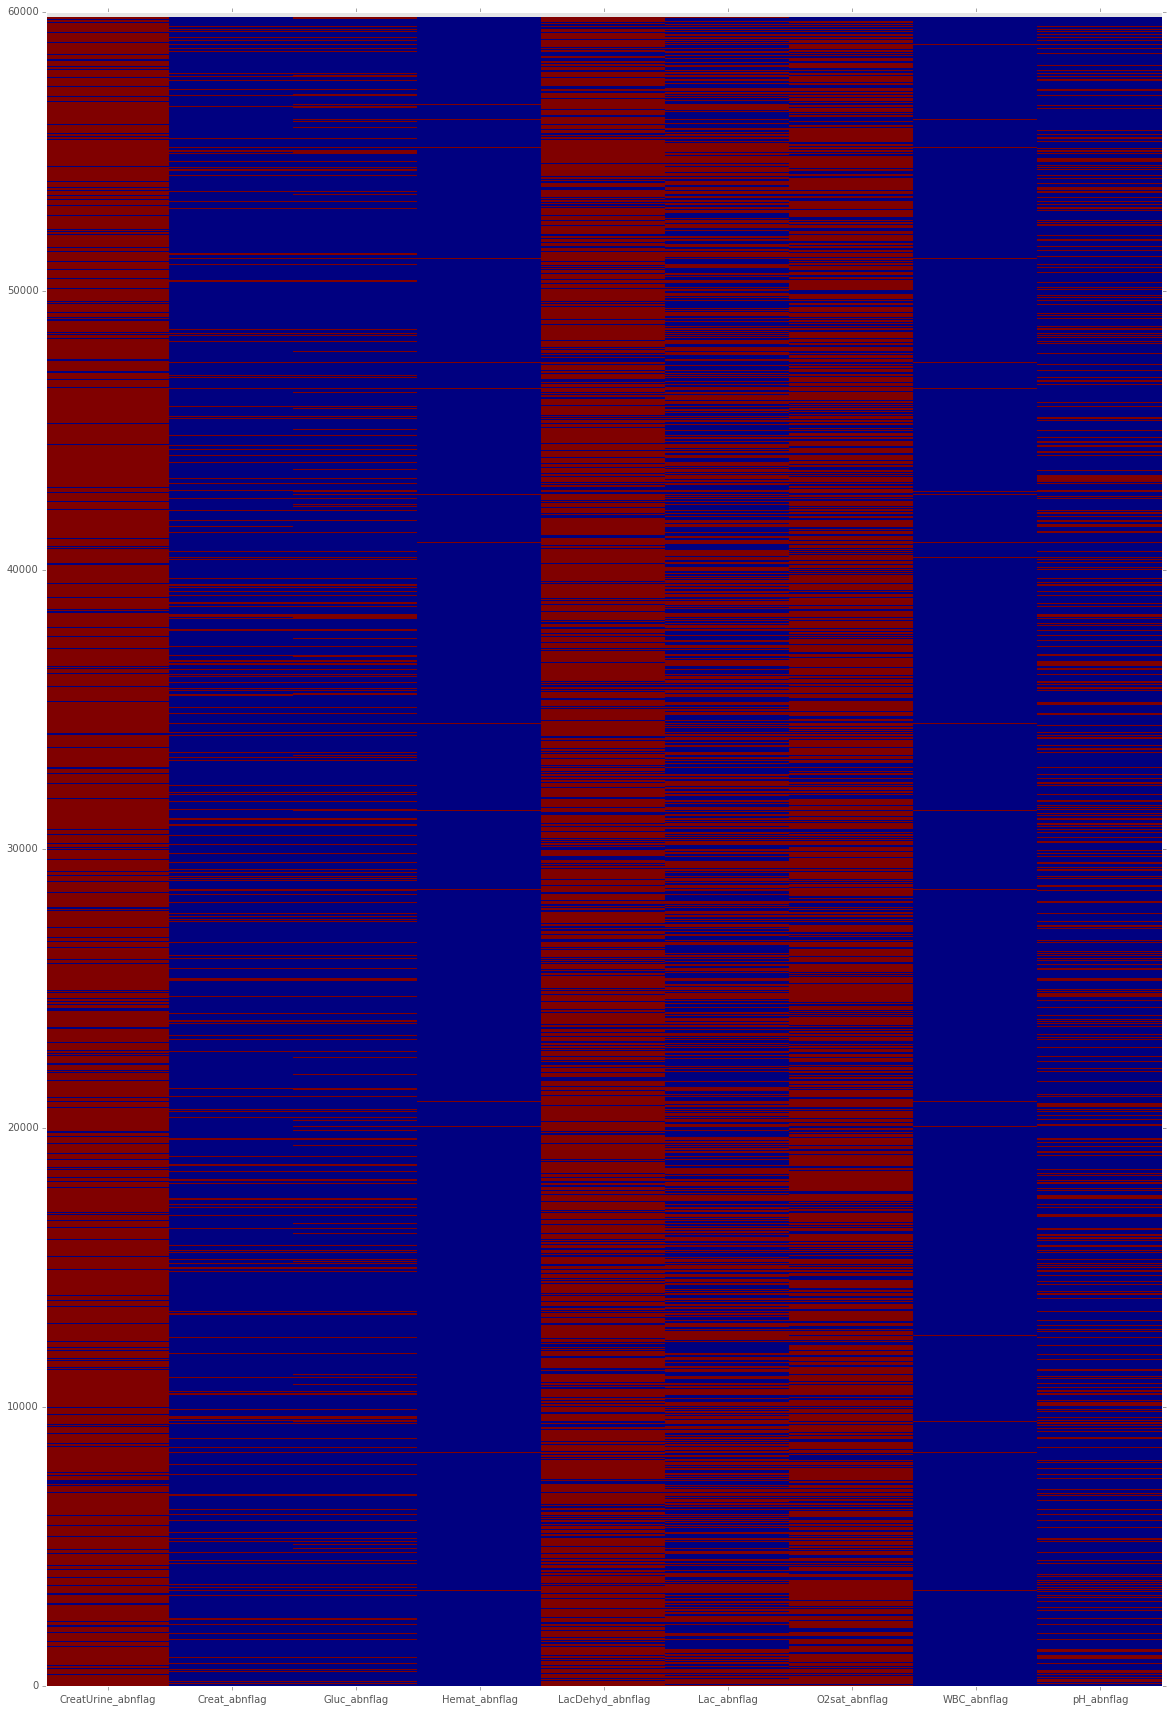

Complete


'\nplt.figure(figsize= (20,10))\nheader = data3[data3.columns[11:18]].replace(np.nan, 10000, inplace = False)\nplt.pcolor(header)\nplt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)\nplt.show()\n'

In [40]:
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (20,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''
plt.figure(figsize= (20,10))
header = data3[data3.columns[11:18]].replace(np.nan, 10000, inplace = False)
plt.pcolor(header)
plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
plt.show()
'''


In [20]:
#header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# BE NAN FREE
missing = data3.copy()
for col in missing.columns:
    missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
monkey = missing.corr()
monkey[monkey >= 0.4]

,subject_id,gender,hospital_expire_flag,pH_std,Hemat_std,Gluc_std,CreatUrine_std,O2sat_std,WBC_std,LacDehyd_std,...,Creat_first,CreatUrine_mean,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
subject_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_expire_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pH_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hemat_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gluc_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreatUrine_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O2sat_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WBC_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LacDehyd_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# REMOVING ALL CREATURINE MEASURES
drop_cols = []
for item in data3.columns: 
    if 'CreatUrine' in item:
        drop_cols.append(item)
#drop_cols

#drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
drop_names = ['LacDehyd', 'O2sat', 'Lac']
drop_measures = ['_std', '_skew', '_slope']
for name in drop_names:
    for ext in drop_measures:
        drop_cols.append(name + ext)
        
drop_cols
        

display(data3.dropna().shape[0])
data4 = data3.drop(drop_cols, inplace = False, axis = 1)
data4.dropna().shape[0]

['CreatUrine_std',
 'CreatUrine_med',
 'CreatUrine_abnflag',
 'CreatUrine_slope',
 'CreatUrine_min',
 'CreatUrine_max',
 'CreatUrine_skew',
 'CreatUrine_delta',
 'CreatUrine_first',
 'CreatUrine_mean']

In [48]:
# CREATING NEW DATAFRAME FOR NORMALIZING DATA AND REMOVING OUTLIERS

cont_cols = list(data4.columns[data4.dtypes == 'float64'])
cont_cols.insert(0, 'hospital_expire_flag')
cont_cols.insert(0, 'gender')
#data4 = data3[list(data3.columns[data3.dtypes == 'float64'])]
data4 = data4[cont_cols]
display(data4.shape)
display(data4.head())

(59798, 73)

,gender,hospital_expire_flag,pH_std,Hemat_std,Gluc_std,WBC_std,Creat_std,WBC_med,O2sat_med,Gluc_med,...,pH_first,Creat_first,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,F,0,1.067085,1.767767,NaN,0.070711,NaN,2.85,92.0,87.0,...,5.00,2.7,2.850000,6.908000,24.850000,87.000000,2.700000,1.400000,92.0,209.0
200003,M,0,0.979600,2.059935,35.501174,15.841191,0.152753,40.20,97.0,110.0,...,5.00,0.9,32.966667,6.998333,33.433333,119.666667,0.866667,3.933333,97.0,203.5
200006,M,0,NaN,6.269237,109.601551,6.091251,0.212132,4.20,NaN,148.5,...,6.00,1.1,7.666667,6.000000,28.666667,148.500000,0.950000,3.100000,NaN,NaN
200007,M,0,NaN,4.454773,30.512293,2.333452,0.057735,9.55,NaN,233.0,...,NaN,0.9,9.550000,NaN,41.250000,242.000000,0.833333,NaN,NaN,NaN
200009,F,0,0.078606,1.609200,NaN,1.604265,0.000000,12.55,98.0,91.0,...,7.46,0.5,12.416667,7.393000,29.542857,91.000000,0.500000,2.000000,98.0,NaN


## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [49]:
# TRANFORMS LIKE BOXCOX REQUIRE POSITIVE DATA SO WE'LL SHIFT DATA POSITIVE
below_zeros = list(data4.columns[data4.min() < 0])
for col in below_zeros:
    col_min = data4[col].min()
    data4.loc[:,col] = data4[col].apply(lambda x: x-col_min)






# create dict from which we'll build skew measures dataframe
skew_dict = {data4.columns[2]:
              {
             'raw_skew': scats.skew(data4[data4.columns[2]].dropna()), 
             'sqrt_skew': scats.skew(np.sqrt(data4[data4.columns[2]].dropna())), 
             'log_skew': scats.skew(np.log(data4[data4.columns[2]].dropna().add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data4[data4.columns[2]].dropna().add(1))[0])
             }
             }

print skew_dict
skew_df = pd.DataFrame.from_dict(skew_dict, orient = 'index')  
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]
skew_df

{'pH_std': {'sqrt_skew': 0.5043617973611405, 'raw_skew': 0.9852769460577677, 'boxcox_skew': 0.3540140671230267, 'log_skew': 0.6990515714452937}}


,raw_skew,sqrt_skew,log_skew,boxcox_skew
pH_std,0.985277,0.504362,0.699052,0.354014


In [50]:
for col in data4.columns[3:]:
    raw_skew = scats.skew(data4[col].dropna())
    
    sqrt_skew = scats.skew(np.sqrt(data4[col].dropna()))
    log_skew = scats.skew(np.log(data4[col].dropna().add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data4[col].dropna().add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'
skew_df

Skewness Values,raw_skew,sqrt_skew,log_skew,boxcox_skew
Lab Measures,,,,
pH_std,0.985277,0.504362,0.699052,0.354014
Hemat_std,1.488803,0.161772,-0.079069,-0.003920
Gluc_std,4.999245,1.666333,-0.127399,0.001782
WBC_std,12.096732,1.316024,0.516079,0.034602
Creat_std,12.591271,1.696145,3.788605,0.271367
WBC_med,19.134085,2.014070,-0.348942,0.056144
O2sat_med,-1.837832,-2.250007,-3.556951,-0.689969
Gluc_med,2.841198,1.528073,0.569327,-0.164396
Hemat_med,1.155539,0.847422,0.553844,-0.013444


## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


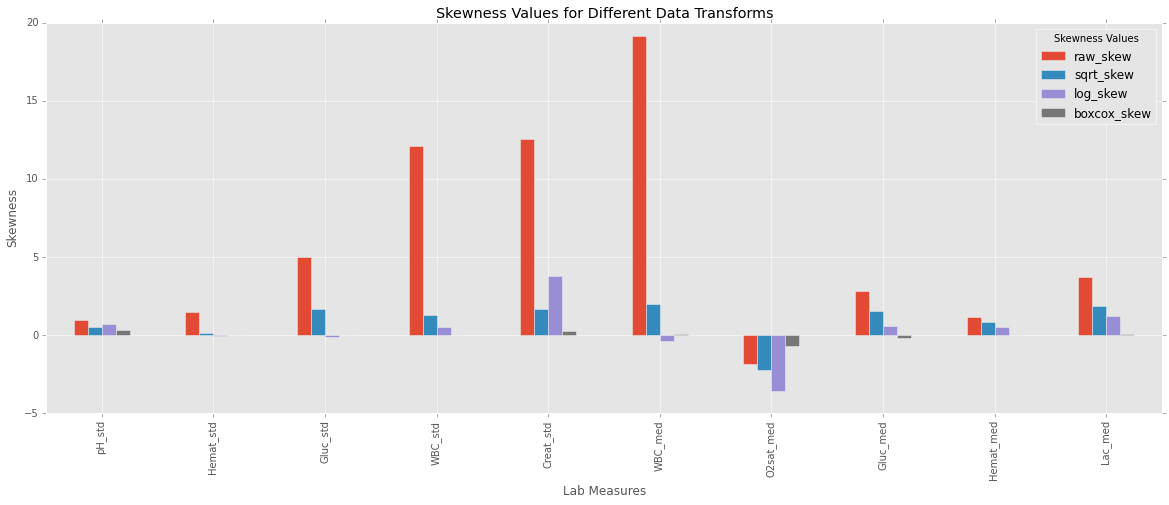

In [52]:
ax = skew_df.head(10).plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [53]:
# VIEW SUMMARY STATISTICS OF DATA4
data4.dropna().describe()

,hospital_expire_flag,pH_std,Hemat_std,Gluc_std,WBC_std,Creat_std,WBC_med,O2sat_med,Gluc_med,Hemat_med,...,pH_first,Creat_first,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
count,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,...,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
mean,0.350868,0.521132,3.135927,48.492561,3.290069,0.276985,14.427459,88.138958,152.261787,31.312779,...,6.803216,2.162496,14.585090,7.100794,31.432770,157.572052,2.078149,3.655225,87.249767,779.329531
std,0.477360,0.406794,1.742933,51.975364,3.167038,0.334330,11.659736,12.186599,64.188847,5.466556,...,0.894549,2.002990,11.530145,0.276195,5.423637,64.819530,1.807350,2.898736,11.893926,1719.151408
min,0.000000,0.005774,0.100000,0.577350,0.000000,0.000000,0.100000,9.000000,38.000000,16.500000,...,5.000000,0.100000,0.075000,5.500000,17.475000,46.333333,0.100000,0.600000,9.000000,87.000000
25%,0.000000,0.105342,1.850217,18.238008,1.386540,0.100000,8.100000,81.500000,112.000000,27.700000,...,6.500000,1.000000,8.400000,6.965079,27.687500,116.791667,0.966667,1.700000,80.666667,227.000000
50%,0.000000,0.478634,2.810160,33.400884,2.444040,0.182574,12.200000,94.000000,139.000000,30.300000,...,7.240000,1.500000,12.350000,7.143636,30.500000,142.428571,1.466667,2.800000,90.666667,326.800000
75%,1.000000,0.844826,4.087297,60.605009,4.219005,0.321455,18.150000,97.000000,174.000000,34.200000,...,7.370000,2.500000,18.366667,7.304808,34.436667,181.000000,2.475000,4.625000,96.500000,585.000000
max,1.000000,1.452733,12.693568,694.285484,36.604915,4.346735,208.200000,100.000000,748.000000,56.750000,...,9.000000,20.100000,213.342857,7.980000,56.150000,718.600000,18.450000,24.300000,234.166667,44466.666667


## TRANSFORM DATA USING BOXCOX METHOD TO MINIMIZE SKEWNESS

In [162]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data4.copy()
boxcox_data.dropna(inplace = True)

# CONVERT FLAGS TO INT VALUES SO THAT I CAN TRANSFORM ONLY FLOAT
cols = list(boxcox_data.columns)
flag_cols = [item for item in boxcox_data.columns if 'abnflag' in item]
for col in flag_cols:
    cols.insert(2, cols.pop(cols.index(col)))
    boxcox_data[col] = boxcox_data[col].astype(int)
boxcox_data = boxcox_data[cols]
display(list(boxcox_data.columns))

for feature_name in boxcox_data[boxcox_data.columns[boxcox_data.dtypes == 'float64']]:
    boxcox_data[feature_name] = scats.boxcox(boxcox_data[feature_name].add(1))[0]


['gender',
 'hospital_expire_flag',
 'Creat_abnflag',
 'Lac_abnflag',
 'O2sat_abnflag',
 'LacDehyd_abnflag',
 'pH_abnflag',
 'WBC_abnflag',
 'Gluc_abnflag',
 'Hemat_abnflag',
 'pH_std',
 'Hemat_std',
 'Gluc_std',
 'WBC_std',
 'Creat_std',
 'WBC_med',
 'O2sat_med',
 'Gluc_med',
 'Hemat_med',
 'Lac_med',
 'Creat_med',
 'LacDehyd_med',
 'pH_med',
 'pH_slope',
 'Hemat_slope',
 'Gluc_slope',
 'WBC_slope',
 'Creat_slope',
 'Gluc_min',
 'Hemat_min',
 'Creat_min',
 'O2sat_min',
 'LacDehyd_min',
 'pH_min',
 'WBC_min',
 'Lac_min',
 'Lac_max',
 'O2sat_max',
 'Gluc_max',
 'LacDehyd_max',
 'Hemat_max',
 'WBC_max',
 'Creat_max',
 'pH_max',
 'pH_skew',
 'WBC_skew',
 'Hemat_skew',
 'Creat_skew',
 'Gluc_skew',
 'pH_delta',
 'Creat_delta',
 'Gluc_delta',
 'Hemat_delta',
 'O2sat_delta',
 'WBC_delta',
 'LacDehyd_delta',
 'Lac_delta',
 'WBC_first',
 'Gluc_first',
 'Hemat_first',
 'Lac_first',
 'LacDehyd_first',
 'O2sat_first',
 'pH_first',
 'Creat_first',
 'WBC_mean',
 'pH_mean',
 'Hemat_mean',
 'Gluc_mean

TypeError: 'Index' object is not callable

In [165]:
# TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# TO USE THESE METHODS WE CREATE A PROPER INDEX
boxcox_data['icustay_id'] = boxcox_data.index
boxcox_data.set_index(np.arange(boxcox_data.shape[0]), inplace = True)
cols = list(boxcox_data.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
boxcox_data = boxcox_data[cols]

In [190]:
boxcox_data.columns

Index([u'icustay_id', u'gender', u'hospital_expire_flag', u'Creat_abnflag',
       u'Lac_abnflag', u'O2sat_abnflag', u'LacDehyd_abnflag', u'pH_abnflag',
       u'WBC_abnflag', u'Gluc_abnflag', u'Hemat_abnflag', u'pH_std',
       u'Hemat_std', u'Gluc_std', u'WBC_std', u'Creat_std', u'WBC_med',
       u'O2sat_med', u'Gluc_med', u'Hemat_med', u'Lac_med', u'Creat_med',
       u'LacDehyd_med', u'pH_med', u'pH_slope', u'Hemat_slope', u'Gluc_slope',
       u'WBC_slope', u'Creat_slope', u'Gluc_min', u'Hemat_min', u'Creat_min',
       u'O2sat_min', u'LacDehyd_min', u'pH_min', u'WBC_min', u'Lac_min',
       u'Lac_max', u'O2sat_max', u'Gluc_max', u'LacDehyd_max', u'Hemat_max',
       u'WBC_max', u'Creat_max', u'pH_max', u'pH_skew', u'WBC_skew',
       u'Hemat_skew', u'Creat_skew', u'Gluc_skew', u'pH_delta', u'Creat_delta',
       u'Gluc_delta', u'Hemat_delta', u'O2sat_delta', u'WBC_delta',
       u'LacDehyd_delta', u'Lac_delta', u'WBC_first', u'Gluc_first',
       u'Hemat_first', u'Lac_first', u'

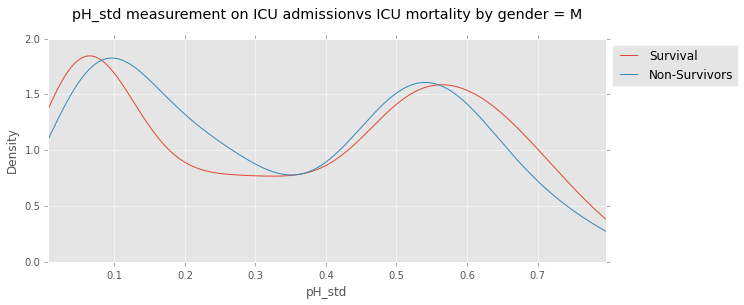

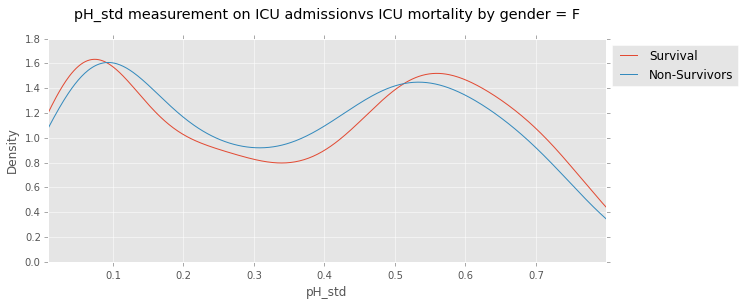

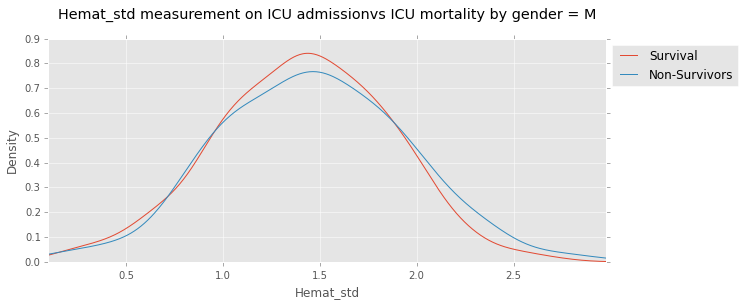

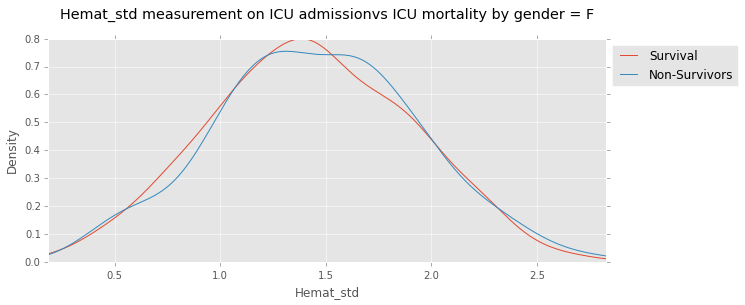

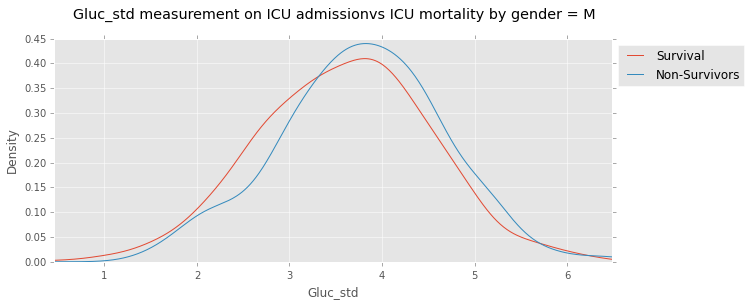

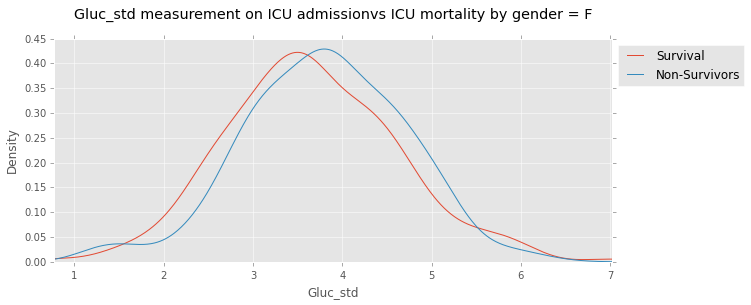

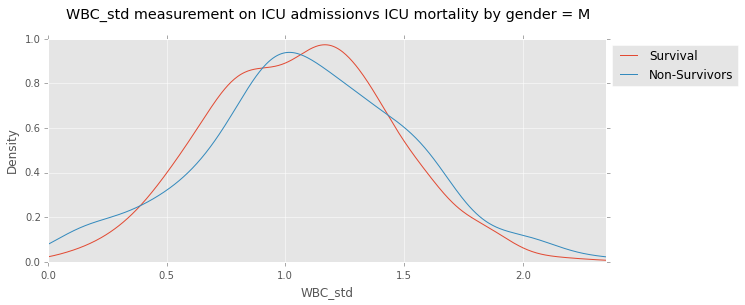

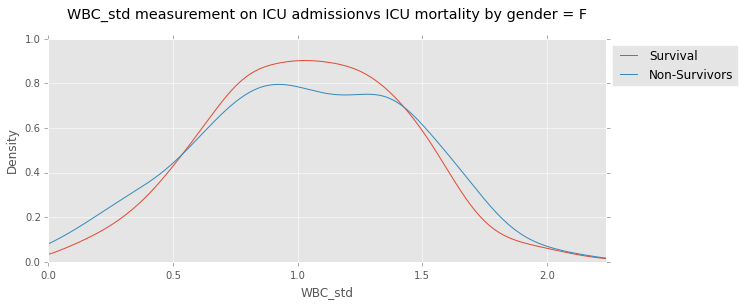

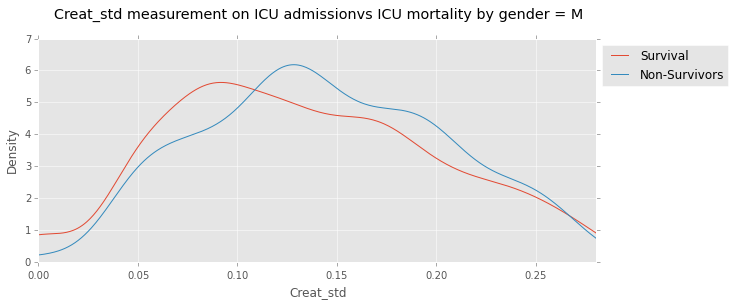

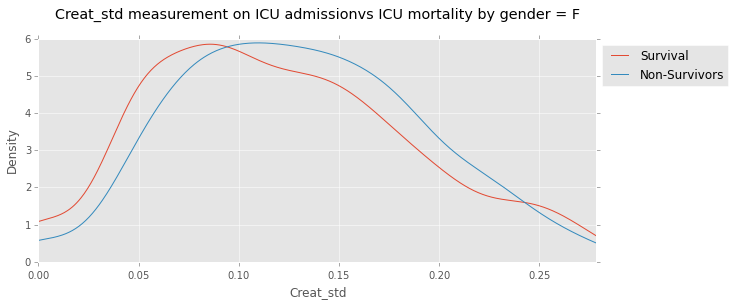

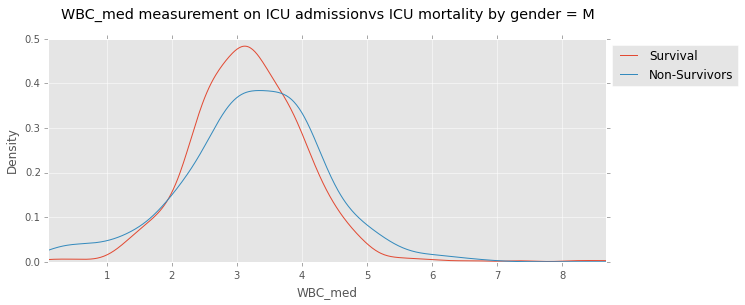

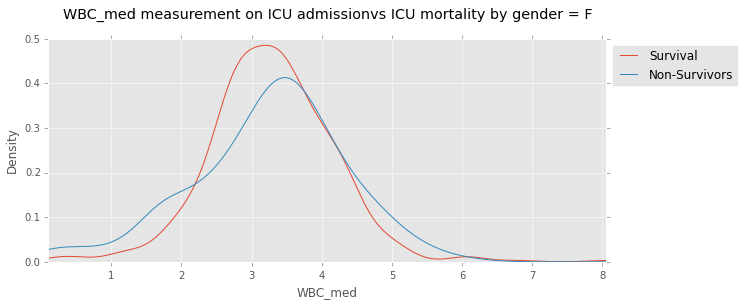

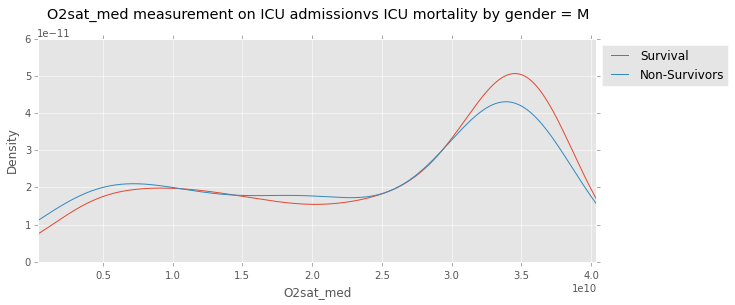

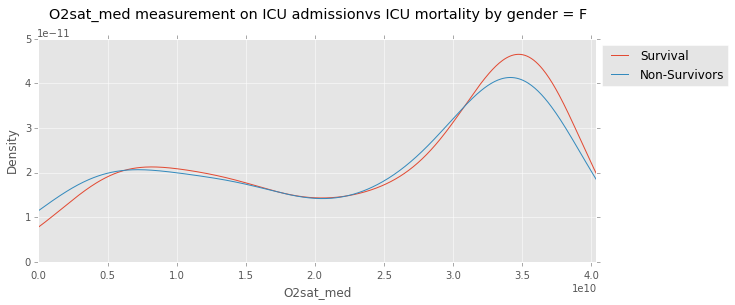

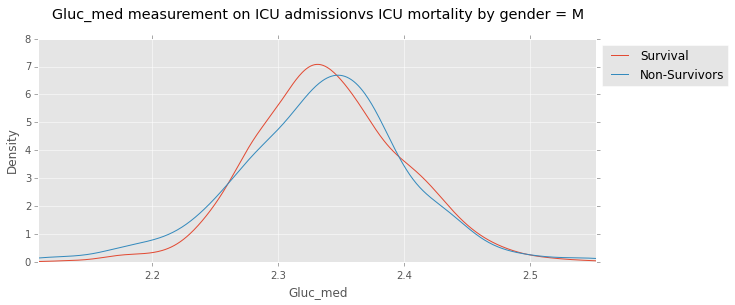

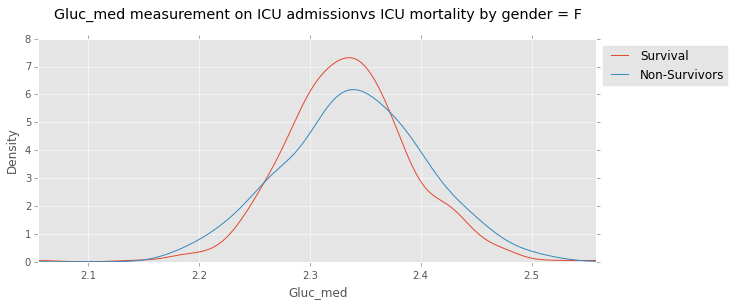

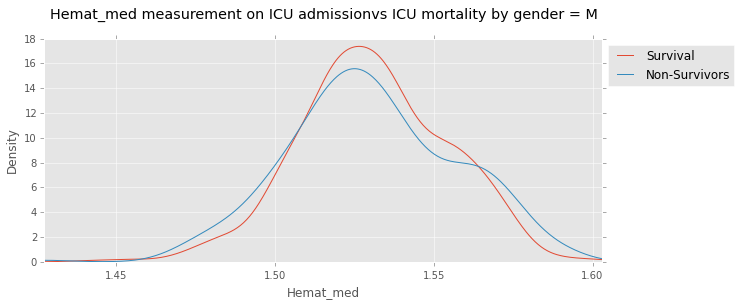

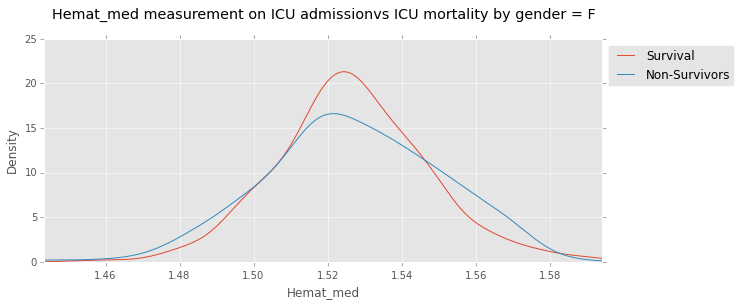

In [191]:
# PLOT FIRST 10 VARIABLES TO SEE WHAT'S WHAT
for col in boxcox_data.columns[11:20]:
    
    
    
    dummy = boxcox_data[['hospital_expire_flag', 'gender', col]].dropna()
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        
        #print gend
        dead = dummy[(dummy.hospital_expire_flag == 1)&
                              (dummy.gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[(dummy.hospital_expire_flag == 0)&
                              (dummy.gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col].dropna().max()#quantile(0.999)
        live_min = live[col].dropna().min()#quantile(0.001)
        dead_max = dead[col].dropna().max()#quantile(0.999)
        dead_min = dead[col].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        if ((live[col].dropna().shape[0] > 10) & (dead[col].dropna().shape[0] > 10)):
            plt.subplots(figsize=(10,4))
            live[col].dropna().plot.kde(alpha=1.0,label='Survival')
            dead[col].dropna().plot.kde(alpha=1.0,label='Non-Survivors')
            # add title, labels etc.
            plt.title('{} measurement on ICU admission'.format(col) + 
                       'vs ICU mortality by gender = {}\n'.format(gend))
            plt.xlabel(col)
            plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
            #print "{}    {}".format(maxlim, minlim)
            plt.xlim(minlim, maxlim)
        else: 
            print "empty data set for {}".format(col)

## Code to identify outliers in normalized data

In [194]:
names_dict = {}
suffix = '_outliers'


# NEED TO DROPNA?
boxcox_data = boxcox_data[cols]

for feature in boxcox_data.columns[11:]:
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature].dropna(), 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature].dropna(), 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove
names_dict

{'Creat_delta_outliers': Int64Index([411, 528, 868, 912, 1596, 1871], dtype='int64'),
 'Creat_first_outliers': Int64Index([], dtype='int64'),
 'Creat_max_outliers': Int64Index([], dtype='int64'),
 'Creat_mean_outliers': Int64Index([], dtype='int64'),
 'Creat_med_outliers': Int64Index([], dtype='int64'),
 'Creat_min_outliers': Int64Index([], dtype='int64'),
 'Creat_skew_outliers': Int64Index([], dtype='int64'),
 'Creat_slope_outliers': Int64Index([344, 1266, 1365, 1871], dtype='int64'),
 'Creat_std_outliers': Int64Index([], dtype='int64'),
 'Gluc_delta_outliers': Int64Index([ 137,  563,  592,  687,  963, 1071, 1129, 1135, 1188, 1207, 1244,
             1283, 1303, 1323, 1347, 1427, 1503, 1515, 1715, 1730, 1859, 1915],
            dtype='int64'),
 'Gluc_first_outliers': Int64Index([998], dtype='int64'),
 'Gluc_max_outliers': Int64Index([], dtype='int64'),
 'Gluc_mean_outliers': Int64Index([], dtype='int64'),
 'Gluc_med_outliers': Int64Index([], dtype='int64'),
 'Gluc_min_outliers': Int64

## Code to remove datapoints from normalized data with 2 or more variables that are outliers

In [195]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)
boxcox_data2.shape

the total outlier indices = 786
the following data points have >2 outlying feature and will be removed: 
[76, 125, 137, 142, 146, 198, 218, 229, 292, 333, 344, 351, 371, 411, 420, 456, 528, 534, 563, 592, 666, 687, 712, 775, 780, 832, 843, 924, 927, 956, 963, 1037, 1071, 1089, 1135, 1143, 1163, 1207, 1244, 1260, 1283, 1288, 1303, 1323, 1347, 1355, 1365, 1379, 1409, 1427, 1452, 1454, 1475, 1492, 1503, 1515, 1579, 1596, 1662, 1699, 1705, 1713, 1715, 1747, 1781, 1800, 1859, 1871, 1912, 1915, 1918, 1925, 1926, 1929, 1969, 1971, 2013]


(1938, 74)

In [199]:

# SCALE DATA 

boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[11:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


,icustay_id,gender,hospital_expire_flag,Creat_abnflag,Lac_abnflag,O2sat_abnflag,LacDehyd_abnflag,pH_abnflag,WBC_abnflag,Gluc_abnflag,...,pH_first,Creat_first,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
0,200003,M,0,0,1,0,0,1,1,1,...,-1.839380,-0.863150,1.724680,-0.584784,0.501338,-0.552435,-0.910731,0.543589,0.876834,-0.917413
1,200030,M,0,1,1,0,0,0,1,1,...,0.674417,0.327555,-0.006450,-0.892344,0.057567,2.330670,0.009886,0.382848,0.434163,-1.643298
2,200102,M,1,1,1,0,1,1,1,1,...,0.653519,0.668813,0.176966,1.086454,-0.272621,0.635960,0.867123,0.915303,-0.444559,-0.001561
3,200159,M,0,0,1,0,0,1,0,0,...,0.716591,-1.759612,-0.721610,0.764499,-0.369550,-1.297459,-1.486354,-0.600782,0.844485,-1.028680
4,200349,F,0,1,1,0,1,1,1,1,...,-1.839380,1.420281,1.029676,-0.244244,-0.732225,1.566079,1.115899,-0.333471,0.779914,-0.311732


,icustay_id,gender,hospital_expire_flag,Creat_abnflag,Lac_abnflag,O2sat_abnflag,LacDehyd_abnflag,pH_abnflag,WBC_abnflag,Gluc_abnflag,...,pH_first,Creat_first,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
0,200003,M,0,0,1,0,0,1,1,1,...,8116.298128,0.485264,4.841458,4.085052e+08,1.381900,2.197244,0.477440,1.091848,406.004950,1.566436
1,200030,M,0,1,1,0,0,0,1,1,...,59909.211588,0.679970,3.250797,3.628371e+08,1.374482,2.340009,0.628181,1.053309,379.882042,1.553114
2,200102,M,1,1,1,0,1,1,1,1,...,59478.646906,0.735774,3.419330,6.566591e+08,1.368962,2.256091,0.768544,1.180969,328.026824,1.583243
3,200159,M,0,0,1,0,0,1,0,0,...,60778.143046,0.338672,2.593667,6.088535e+08,1.367342,2.160352,0.383188,0.817476,404.095985,1.564394
4,200349,F,0,1,1,0,1,1,1,1,...,8116.298128,0.858655,4.202849,4.590703e+08,1.361279,2.302148,0.809279,0.881566,400.285496,1.577551


In [200]:
boxcox_scaled_stats = boxcox_data_scaled.describe()

In [208]:
boxcox_data_scaled.columns[11:]

Index([u'pH_std', u'Hemat_std', u'Gluc_std', u'WBC_std', u'Creat_std',
       u'WBC_med', u'O2sat_med', u'Gluc_med', u'Hemat_med', u'Lac_med',
       u'Creat_med', u'LacDehyd_med', u'pH_med', u'pH_slope', u'Hemat_slope',
       u'Gluc_slope', u'WBC_slope', u'Creat_slope', u'Gluc_min', u'Hemat_min',
       u'Creat_min', u'O2sat_min', u'LacDehyd_min', u'pH_min', u'WBC_min',
       u'Lac_min', u'Lac_max', u'O2sat_max', u'Gluc_max', u'LacDehyd_max',
       u'Hemat_max', u'WBC_max', u'Creat_max', u'pH_max', u'pH_skew',
       u'WBC_skew', u'Hemat_skew', u'Creat_skew', u'Gluc_skew', u'pH_delta',
       u'Creat_delta', u'Gluc_delta', u'Hemat_delta', u'O2sat_delta',
       u'WBC_delta', u'LacDehyd_delta', u'Lac_delta', u'WBC_first',
       u'Gluc_first', u'Hemat_first', u'Lac_first', u'LacDehyd_first',
       u'O2sat_first', u'pH_first', u'Creat_first', u'WBC_mean', u'pH_mean',
       u'Hemat_mean', u'Gluc_mean', u'Creat_mean', u'Lac_mean', u'O2sat_mean',
       u'LacDehyd_mean'],
      dtype=

In [209]:
z
boxcox_data_cat = boxcox_data_scaled.copy()


for col in boxcox_data_scaled.columns[11:]:
    Q1 = boxcox_scaled_stats[col].loc['25%']
    Q2 = boxcox_scaled_stats[col].loc['50%']
    Q3 = boxcox_scaled_stats[col].loc['75%']
    boxcox_data_cat[col] = boxcox_data_scaled[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))
                                                    
     
    
    

In [286]:
boxcox_data_cat[boxcox_data_cat.columns[10:]].head()

,Hemat_abnflag,pH_std,Hemat_std,Gluc_std,WBC_std,Creat_std,WBC_med,O2sat_med,Gluc_med,Hemat_med,...,pH_first,Creat_first,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
0,1,Q3,Q1,Q2,Q3,Q1,Q3,Q2,Q0,Q2,...,Q0,Q0,Q3,Q1,Q2,Q1,Q0,Q2,Q3,Q0
1,1,Q3,Q1,Q3,Q1,Q3,Q2,Q2,Q3,Q1,...,Q2,Q2,Q2,Q0,Q2,Q3,Q2,Q2,Q2,Q0
2,1,Q0,Q1,Q3,Q0,Q2,Q2,Q1,Q3,Q1,...,Q2,Q2,Q2,Q3,Q1,Q2,Q3,Q3,Q1,Q2
3,1,Q0,Q2,Q0,Q0,Q0,Q0,Q2,Q0,Q1,...,Q3,Q0,Q0,Q2,Q1,Q0,Q0,Q1,Q2,Q0
4,1,Q3,Q1,Q3,Q1,Q3,Q3,Q2,Q3,Q0,...,Q0,Q3,Q3,Q1,Q0,Q3,Q3,Q1,Q2,Q1


In [287]:
# CONVERT CATEGORICAL DATA TO DUMMY VARIABLES FOR FEATURE SELECTION 
cols1 = boxcox_data_cat.columns[:11]
cols2 = boxcox_data_cat.columns[11:]
boxcox_dummies1 = boxcox_data_cat[cols1].copy()
display(boxcox_dummies1.head())
boxcox_dummies = boxcox_dummies1.merge(pd.get_dummies(boxcox_data_cat[cols2]), left_index = True, 
                                                     right_index = True, how = 'left', sort = True)
boxcox_dummies.head()

,icustay_id,gender,hospital_expire_flag,Creat_abnflag,Lac_abnflag,O2sat_abnflag,LacDehyd_abnflag,pH_abnflag,WBC_abnflag,Gluc_abnflag,Hemat_abnflag
0,200003,M,0,0,1,0,0,1,1,1,1
1,200030,M,0,1,1,0,0,0,1,1,1
2,200102,M,1,1,1,0,1,1,1,1,1
3,200159,M,0,0,1,0,0,1,0,0,1
4,200349,F,0,1,1,0,1,1,1,1,1


,icustay_id,gender,hospital_expire_flag,Creat_abnflag,Lac_abnflag,O2sat_abnflag,LacDehyd_abnflag,pH_abnflag,WBC_abnflag,Gluc_abnflag,...,Lac_mean_Q2,Lac_mean_Q3,O2sat_mean_Q0,O2sat_mean_Q1,O2sat_mean_Q2,O2sat_mean_Q3,LacDehyd_mean_Q0,LacDehyd_mean_Q1,LacDehyd_mean_Q2,LacDehyd_mean_Q3
0,200003,M,0,0,1,0,0,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,200030,M,0,1,1,0,0,0,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,200102,M,1,1,1,0,1,1,1,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,200159,M,0,0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,200349,F,0,1,1,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## FEATURE SELECTION ON VARIABLES

In [242]:
# DIVIDE FEATURES FROM TARGETS

X_continuous = boxcox_dummies[boxcox_dummies.columns[3:]]
y = boxcox_dummies['hospital_expire_flag']
display(X_continuous.shape)
display(y.shape)

# SELECT K BEST FEATURES BASED ON CHI2 SCORES
selector = SelectKBest(score_func = chi2)
selector.fit(X_continuous, y)
'''
print "p_vals            scores           feature"
for i in range(len(selector.pvalues_)):
    print "{}    {}   {}".format(selector.pvalues_[i], selector.scores_[i], X_continuous.columns[i])
X_new, p_vals = SelectKBest(chi2, k=10).fit_transform(X_continuous, y)
X_new.shape
'''

largest = pd.Series(selector.scores_).nlargest(40)
X_continuous.columns[largest.index]

p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
cont_features_df = pd.concat([p_vals, scores], axis = 1)
cont_features_df.sort_values(by ='scores', ascending = False).head(40)

(1938, 254)

(1938,)

p_vals            scores           feature


,p_values,scores
Lac_mean_Q3,6.114344e-25,106.371084
Lac_min_Q3,4.297593e-23,97.946874
Lac_med_Q3,1.494109e-22,95.479762
Lac_max_Q3,7.710540e-22,92.231557
Lac_first_Q3,9.712515e-15,59.953500
Lac_delta_Q3,6.634786e-13,51.649490
LacDehyd_max_Q3,1.478470e-12,50.076770
LacDehyd_min_Q3,2.924941e-12,48.738328
LacDehyd_med_Q3,2.147092e-11,44.831782
LacDehyd_mean_Q3,2.147092e-11,44.831782


In [289]:
boxcox_dummies[['icustay_id', 'hospital_expire_flag']].head()

,icustay_id,hospital_expire_flag
0,200003,0
1,200030,0
2,200102,1
3,200159,0
4,200349,0


In [290]:
largest = pd.Series(selector.scores_).nlargest(20)
cols = list(X_continuous.columns[largest.index])
#cols.insert(0, 'hospital_expire_flag')
#cols.insert(0, 'gender')
#cols.insert(0, 'icustay_id')
base = boxcox_dummies[['icustay_id', 'hospital_expire_flag']]
select_features = boxcox_dummies[cols]
boxcox_dummies2 = base.merge(select_features, left_index = True, 
                                                     right_index = True, how = 'left', sort = True)



boxcox_dummies2.head()

,icustay_id,hospital_expire_flag,Lac_mean_Q3,Lac_min_Q3,Lac_med_Q3,Lac_max_Q3,Lac_first_Q3,Lac_delta_Q3,LacDehyd_max_Q3,LacDehyd_min_Q3,...,Lac_min_Q0,LacDehyd_first_Q3,Lac_med_Q0,pH_med_Q0,Lac_mean_Q0,Creat_max_Q0,pH_max_Q0,Lac_first_Q0,pH_med_Q3,Lac_max_Q0
0,200003,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,200030,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,200102,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,200159,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,200349,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [298]:
boxcox_dummies2.columns[1:]

Index([u'hospital_expire_flag', u'Lac_mean_Q3', u'Lac_min_Q3', u'Lac_med_Q3',
       u'Lac_max_Q3', u'Lac_first_Q3', u'Lac_delta_Q3', u'LacDehyd_max_Q3',
       u'LacDehyd_min_Q3', u'LacDehyd_med_Q3', u'LacDehyd_mean_Q3',
       u'Lac_min_Q0', u'LacDehyd_first_Q3', u'Lac_med_Q0', u'pH_med_Q0',
       u'Lac_mean_Q0', u'Creat_max_Q0', u'pH_max_Q0', u'Lac_first_Q0',
       u'pH_med_Q3', u'Lac_max_Q0'],
      dtype='object')

In [299]:
#boxcox_dummies[['hospital_expire_flag', 'Lac_mean_Q3']].boxplot(by = 'hospital_expire_flag')
cols = boxcox_dummies2.columns[1:]
monkey = boxcox_dummies2[cols].groupby('hospital_expire_flag').sum()/boxcox_dummies2[cols].groupby('hospital_expire_flag').count()
display(boxcox_dummies2['hospital_expire_flag'].sum())
display(boxcox_dummies2['hospital_expire_flag'].count())
survivors = boxcox_dummies2['hospital_expire_flag'].sum()

678

1938

In [300]:
monkey

,Lac_mean_Q3,Lac_min_Q3,Lac_med_Q3,Lac_max_Q3,Lac_first_Q3,Lac_delta_Q3,LacDehyd_max_Q3,LacDehyd_min_Q3,LacDehyd_med_Q3,LacDehyd_mean_Q3,Lac_min_Q0,LacDehyd_first_Q3,Lac_med_Q0,pH_med_Q0,Lac_mean_Q0,Creat_max_Q0,pH_max_Q0,Lac_first_Q0,pH_med_Q3,Lac_max_Q0
hospital_expire_flag,,,,,,,,,,,,,,,,,,,,
0,0.164286,0.158730,0.161905,0.165873,0.185714,0.175397,0.191270,0.192063,0.194444,0.194444,0.316667,0.197619,0.303968,0.203968,0.300794,0.314286,0.223810,0.320635,0.280952,0.315079
1,0.410029,0.389381,0.390855,0.392330,0.370206,0.340708,0.359882,0.358407,0.353982,0.353982,0.157817,0.348083,0.154867,0.351032,0.156342,0.174041,0.364307,0.181416,0.151917,0.181416


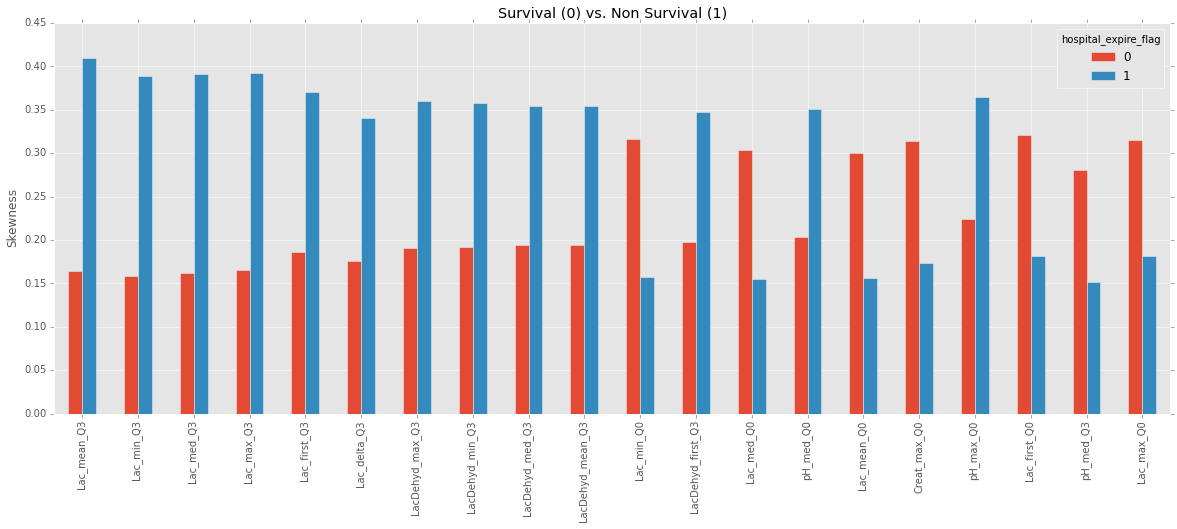

In [301]:
ax = monkey.transpose().plot.bar(figsize = (20,7), title = 'Survival (0) vs. Non Survival (1)', stacked = False)
ax.set_ylabel("Skewness")

# XXXXXXXXXXXXXXXXX

In [310]:
dead = boxcox_dummies2['hospital_expire_flag'][boxcox_dummies2['hospital_expire_flag']== 1].count()
dead

678

In [311]:

dead = boxcox_dummies2['hospital_expire_flag'][boxcox_dummies2['hospital_expire_flag']==1].count()
survivors = boxcox_dummies2['hospital_expire_flag'][boxcox_dummies2['hospital_expire_flag']==0].count()
survival_rate = float(survivors)/(dead+survivors)
print "Number of  patients deceased = {}".format(dead)
print "Number of patients           = {}".format(dead + survivors)
print "Survival Rate                = {}".format(survival_rate * 100)

Number of  patients deceased = 678
Number of patients           = 1938
Survival Rate                = 65.0154798762


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [351]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_dummies2[boxcox_dummies2.columns[2:]], 
                                                    boxcox_dummies2['hospital_expire_flag'], 
                                                    test_size = 0.30, random_state = 42)

In [352]:
clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight={1 : 1.3, 0 : 1}, coef0=0.0,
    decision_function_shape='ovo', degree=2, gamma='auto', kernel='poly', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_dummies2[boxcox_dummies2.columns[2:]], 
                         boxcox_dummies2['hospital_expire_flag'], cv=5)
display(scores)  


clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

array([ 0.68814433,  0.70103093,  0.68041237,  0.70542636,  0.75193798])

array([[350,  31],
       [141,  60]])

In [353]:
clf_Tree = DecisionTreeClassifier(random_state = 0, max_features = 6)
scores = cross_val_score(clf_Tree, boxcox_dummies2[boxcox_dummies2.columns[2:]], 
                         boxcox_dummies2['hospital_expire_flag'], cv=5)
display(scores)  

clf_Tree.fit(X_train, y_train)
clf_Tree.score(X_test, y_test)
y_predsTree = clf_Tree.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsTree))

array([ 0.64175258,  0.67783505,  0.65463918,  0.64341085,  0.69509044])

array([[317,  64],
       [128,  73]])

## The Confusion Matrix indicates that the classifier simply predicts survival for each patient which, because 82% of the patients survived, results in 82% Accuracy. 

## Gaussian Naive Bayes Classification on un-processed data with variables selected based on visual inspection

In [331]:

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.664948453608


array([[193,  58],
       [ 72,  65]])

## The Confusion Matrix indicates that the classifier predicts survival rates with ~78% accuracy with a mixture of predictions rather than predicting all survival as was the case for the SVM classifier. Unfortunately, the accuracy is not better than predicting all survivors. 

## Multi-Layer Perceptron Classification on un-processed data with variables selected based on visual inspection

In [337]:
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=42)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




0.70618556701030932

array([[221,  30],
       [ 84,  53]])

# WRITING THE HIGHEST SCORED LAB FEATURES TO FILE FOR USE IN CLASSIFICATION

In [354]:
boxcox_dummies2.to_csv('LABEVENTS_FIRST24_preproc.csv')


#           OLD CODE

In [ ]:
# PLOTTING CATEGORICAL VARIABLES

for thing in cat_vars:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)

    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
# PLOTTING INTEGER VARIABLES

for thing in int_vars[1:len(int_vars)-1]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        #total = float(live) + dead
        #datadict[cat] = (live/total, dead/total)
        datadict[cat] = (live, dead)
    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
# PLOTTING FLOAT VARIABLES

for thing in float_vars:
    # plot
    plt.subplots(figsize=(13,6))
    data5[thing][data5.hospital_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    data5[thing][data5.hospital_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')
    
  

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(thing.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(thing)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data5[thing].dropna().quantile(0.99))
    
  

In [ ]:
dead_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==1)].dropna().count()
dead_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==1)].dropna().count()
live_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==0)].dropna().count()
live_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==0)].dropna().count()
survival = pd.DataFrame([[live_men, live_women], 
                        [dead_men, dead_women]], 
                       columns = ['Men', 'Women'],
                       index = ['Survivors', 'Non_Survivors'])
survival

survival.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                             alpha = 0.5)

np.arange(2)

ind = np.arange(1,3)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

plt.figure(figsize= (20,10))
p1 = plt.bar(ind - width/2, survival.iloc[0], width, color = 'green', edgecolor = 'black',
            linewidth = 3)
p2 = plt.bar(ind - width/2, survival.iloc[1], width, color = 'red', edgecolor = 'black', 
             linewidth = 3, bottom=survival.iloc[0])

plt.ylabel('Number of Patients')
plt.title('Survivors vs. Non-Survivors')
plt.xticks(ind, ('Men', 'Women'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Survivors', 'Non_Survivors'))

plt.show()

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Generating box-plots for each variable for both survival and non-survival groups. 

In [ ]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

## From the density plots above, a list of variables was generated for which the distribution was very similar between survival and non-survival groups. (Maybe include similarity threshold??)

In [ ]:
# Generate list of variables which, from density plots above, are similar between surivial and non-survival groups
cols_list = list(data.columns)
remove_list = ['chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'platelet_1st']
for element in remove_list:
    cols_list.remove(element)
    
display(cols_list)

In [ ]:
# data4 includes all variables except those identified as similar between survival and non-survival groups. 
data2 = data[cols_list]
data2.head()

## Removing data points that include any NaN values

In [ ]:
# remove samples which have any values that are nan
data2 = data2.dropna()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

## The survival rate calculated below indicates that 82% of patients survived. 

## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [ ]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2.columns[1]:
              {
             'raw_skew': scats.skew(data2[data2.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2[data2.columns[1]])), 
             'log_skew': scats.skew(np.log(data2[data2.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2[data2.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

In [ ]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [ ]:
skew_df

In [ ]:
              
for col in data2.columns[2:]:
    raw_skew = scats.skew(data2[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2[col]))
    log_skew = scats.skew(np.log(data2[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

In [ ]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


In [ ]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [ ]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data2.copy()
for feature_name in data2.columns[1:]:
    boxcox_data[feature_name] = scats.boxcox(data2[feature_name].add(1))[0]

boxcox_data.head()

## Code to identify outliers in normalized data

In [ ]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [ ]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

In [ ]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


In [ ]:
#remove_list

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs_dict2 = labs_dict

# could be done more succinctly using the dictionary described above

for item in remove_list:
    del labs_dict2[item]

print labs_dict2
print boxcox_data_scaled.columns

import collections
labs_dict3 = collections.OrderedDict(sorted(labs_dict2.items()))
labs_dict3
'''

## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().count()
    n_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().median()
    med_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().median()
    var_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().var()
    var_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().var()
    skew_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().skew()
    skew_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna(),
                              boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data_scaled[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Performing PCA on box-cox transformed, scaled data with outliers removed

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 4).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

In [ ]:
pd.scatter_matrix(boxcox_data_scaled[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, 
                                                    boxcox_data_scaled['mort_icu'], test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                                                    boxcox_data_scaled['mort_icu'], test_size = 0.40, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
boxcox_dead = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 1]
boxcox_survivors = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 0]
display(boxcox_dead.shape[0])
display(boxcox_survivors.shape[0])
boxcox_survivors_reduced = boxcox_survivors.sample(boxcox_dead.shape[0])
frames = [boxcox_survivors_reduced, boxcox_dead]
boxcox_even = pd.concat(frames)
boxcox_even.shape

In [ ]:
num_samps = boxcox_even.shape[0]
display(num_samps)

boxcox_even2 = boxcox_even.sample(n=num_samps)
#boxcox_even2.shape()
boxcox_even2.shape

In [ ]:
boxcox_even2.head(10)

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)



clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                         boxcox_data_scaled['mort_icu'], cv=5)
display(scores)  
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
display(clf_SVC.score(X_test, y_test))
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
print "monkey"

In [ ]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes.head()

In [ ]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))

In [ ]:
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape


In [ ]:
unique_codes.head()

In [ ]:
len(diagnoses_list)

In [ ]:
diag_counts = diagnoses_codes.icd9_code.value_counts()

In [ ]:
diag_counts[0:10]

In [ ]:
diagnoses_list[0:10]

In [ ]:
boxcox_data_scaled.columns

In [ ]:
boxcox_data_scaled_subset = boxcox_data_scaled[['mort_icu', 'albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st',
                                                'ptt_1st']]
boxcox_data_scaled_subset.head()

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 3).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
feat_list = list(boxcox_data_scaled_subset.columns[1:])
feat_list

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled_subset[feat_list], 
                                                    boxcox_data_scaled_subset['mort_icu'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)
